# **Packages**

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

# **Read Data from CSV File**

In [141]:
df = pd.read_csv('FAOSTAT.csv',encoding='latin1').reset_index(drop=True).rename(index=lambda x: x + 1)
df.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
1,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371,"Almonds, in shell",2019,2019,ha,29203.0,A,Official figure,NaN
2,QCL,Crops and livestock products,4,Afghanistan,5412,Yield,1371,"Almonds, in shell",2019,2019,kg/ha,1308.3,A,Official figure,NaN
3,QCL,Crops and livestock products,4,Afghanistan,5510,Production,1371,"Almonds, in shell",2019,2019,t,38205.0,A,Official figure,NaN
4,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371,"Almonds, in shell",2020,2020,ha,22134.0,A,Official figure,NaN
5,QCL,Crops and livestock products,4,Afghanistan,5412,Yield,1371,"Almonds, in shell",2020,2020,kg/ha,1775.9,A,Official figure,NaN


# **Data Preprocessing**

In [142]:
df.dtypes

Domain Code          object
Domain               object
Area Code             int64
Area                 object
Element Code          int64
Element              object
Item Code            object
Item                 object
Year Code             int64
Year                  int64
Unit                 object
Value               float64
Flag                 object
Flag Description     object
Note                 object
dtype: object

In [143]:
df.drop(['Domain Code','Domain','Flag','Flag Description','Note','Item Code','Year Code'], axis=1, inplace=True)

In [144]:
df = df.dropna(subset=['Value'])

In [145]:
df.isnull().sum()

Area Code       0
Area            0
Element Code    0
Element         0
Item            0
Year            0
Unit            0
Value           0
dtype: int64

In [146]:
def normalize_value_and_unit(row):
    unit = row['Unit']
    value = row['Value']
    
    # Group 1: Convert to mg/An
    if unit == '100 mg/An':
        return value * 100, 'mg/No'
    elif unit == '0.1 g/An':
        return value * 100, 'mg/No'
    elif unit == '100 g/An':
        return value * 100000, 'mg/No'
    
    # Group 2 : Convert to No
    elif unit == '1000 An' or unit == '1000 No':
        return value * 1000, 'No'
    elif unit == 'An' or unit == 'No':
        return value, 'No'

    # Group 3: ha 
    elif unit == 'ha':
        return value, 'ha'

    # Group 4: kg/ha 
    elif unit == 'kg/ha':
        return value, 'kg/ha'

    # Group 5: tonnes 
    elif unit == 't':
        return value, 't'

    # Group 7: No/An 
    elif unit == 'No/An':
        return value, 'No/An'

    # Unknown unit
    else:
        return None, None

# Apply the function to the DataFrame
df = df.copy()
df[['Measured_Value', 'Units']] = df.apply(normalize_value_and_unit, axis=1, result_type='expand')

In [147]:
df=df.drop(['Unit','Value'], axis=1)
df.reset_index(drop=True).rename(index=lambda x: x + 1)

,Area Code,Area,Element Code,Element,Item,Year,Measured_Value,Units
1,4,Afghanistan,5312,Area harvested,"Almonds, in shell",2019,29203.00,ha
2,4,Afghanistan,5412,Yield,"Almonds, in shell",2019,1308.30,kg/ha
3,4,Afghanistan,5510,Production,"Almonds, in shell",2019,38205.00,t
4,4,Afghanistan,5312,Area harvested,"Almonds, in shell",2020,22134.00,ha
5,4,Afghanistan,5412,Yield,"Almonds, in shell",2020,1775.90,kg/ha
...,...,...,...,...,...,...,...,...
218126,716,Zimbabwe,5510,Production,"Whole milk, condensed",2022,752.48,t
218127,716,Zimbabwe,5510,Production,"Whole milk, evaporated",2019,5010.21,t
218128,716,Zimbabwe,5510,Production,"Whole milk, evaporated",2020,4795.70,t
218129,716,Zimbabwe,5510,Production,"Whole milk, evaporated",2021,4921.05,t


In [148]:
special_items = [
    'Beer of barley, malted',
    'Raw cane or beet sugar (centrifugal only)',
    'Molasses',
    'Soya bean oil',
    'Cotton seed',
    'Green tea (not fermented), black tea (fermented) and partly fermented tea, in immediate packings of a content not exceeding 3 kg',
    'Groundnut oil',
    'Cotton lint, ginned',
    'Shorn wool, greasy, including fleece-washed shorn wool',
    'Cottonseed oil',
    'Sunflower-seed oil, crude',
    'Mushrooms and truffles',
    'Wine',
    'Coconut oil',
    'Rapeseed or canola oil, crude',
    'Oil of sesame seed',
    'Oil of linseed',
    'Oil of maize',
    'Palm oil',
    'Oil of palm kernel',
    'Palm kernels',
    'Olive oil',
    'Coir, raw',
    'Brazil nuts, in shell',
    'Kapok fibre, raw',
    'Kapokseed in shell'
]
area_items = df[df['Element'] == 'Area harvested']['Item'].unique()
df_crop = df[
    (df['Item'].isin(area_items) | df['Item'].isin(special_items)) &
    (df['Element'].isin(['Area harvested', 'Yield', 'Production']))
].reset_index(drop=True).rename(index=lambda x: x + 1)
df_crop

,Area Code,Area,Element Code,Element,Item,Year,Measured_Value,Units
1,4,Afghanistan,5312,Area harvested,"Almonds, in shell",2019,29203.0,ha
2,4,Afghanistan,5412,Yield,"Almonds, in shell",2019,1308.3,kg/ha
3,4,Afghanistan,5510,Production,"Almonds, in shell",2019,38205.0,t
4,4,Afghanistan,5312,Area harvested,"Almonds, in shell",2020,22134.0,ha
5,4,Afghanistan,5412,Yield,"Almonds, in shell",2020,1775.9,kg/ha
...,...,...,...,...,...,...,...,...
148176,716,Zimbabwe,5412,Yield,Wheat,2022,5154.2,kg/ha
148177,716,Zimbabwe,5510,Production,Wheat,2022,250000.0,t
148178,716,Zimbabwe,5312,Area harvested,Wheat,2023,65878.0,ha
148179,716,Zimbabwe,5412,Yield,Wheat,2023,4553.8,kg/ha


In [149]:
df_livestock = df.merge(df_crop.drop_duplicates(), 
                          on=['Area Code', 'Area', 'Element Code', 'Element', 'Item', 'Year', 'Measured_Value', 'Units'],
                          how='left', 
                          indicator=True)
df_livestock = df_livestock[df_livestock['_merge'] == 'left_only'].drop(columns=['_merge']).reset_index(drop=True).rename(index=lambda x: x + 1)
df_livestock

,Area Code,Area,Element Code,Element,Item,Year,Measured_Value,Units
1,4,Afghanistan,5111,Stocks,Asses,2019,1402909.00,No
2,4,Afghanistan,5111,Stocks,Asses,2020,1520555.00,No
3,4,Afghanistan,5111,Stocks,Asses,2021,1493288.00,No
4,4,Afghanistan,5111,Stocks,Asses,2022,1506699.00,No
5,4,Afghanistan,5111,Stocks,Asses,2023,1520111.00,No
...,...,...,...,...,...,...,...,...
69946,716,Zimbabwe,5510,Production,"Whole milk, condensed",2022,752.48,t
69947,716,Zimbabwe,5510,Production,"Whole milk, evaporated",2019,5010.21,t
69948,716,Zimbabwe,5510,Production,"Whole milk, evaporated",2020,4795.70,t
69949,716,Zimbabwe,5510,Production,"Whole milk, evaporated",2021,4921.05,t


In [150]:
df_crop['Element_with_unit'] = df_crop['Element'] + ' (' + df_crop['Units'] + ')'
df_crop = df_crop.pivot_table(
    index=['Area Code','Area', 'Item', 'Year'],
    columns='Element_with_unit',
    values='Measured_Value'
).reset_index()
df_crop.columns.name = None
df_crop

,Area Code,Area,Item,Year,Area harvested (ha),Production (t),Yield (kg/ha)
0,4,Afghanistan,"Almonds, in shell",2019,29203.0,38205.00,1308.3
1,4,Afghanistan,"Almonds, in shell",2020,22134.0,39307.00,1775.9
2,4,Afghanistan,"Almonds, in shell",2021,36862.0,64256.00,1743.2
3,4,Afghanistan,"Almonds, in shell",2022,36462.0,63515.00,1742.0
4,4,Afghanistan,"Almonds, in shell",2023,37000.0,67000.00,1810.8
...,...,...,...,...,...,...,...
55475,894,Zambia,Wheat,2019,22706.0,151850.47,6687.8
55476,894,Zambia,Wheat,2020,26007.0,191619.80,7368.0
55477,894,Zambia,Wheat,2021,30319.0,205881.95,6790.5
55478,894,Zambia,Wheat,2022,33568.0,234924.63,6998.6


In [151]:
df_crop = df_crop.fillna(0)

In [152]:
df_crop.isnull().sum()

Area Code              0
Area                   0
Item                   0
Year                   0
Area harvested (ha)    0
Production (t)         0
Yield (kg/ha)          0
dtype: int64

In [153]:
df_livestock['Element_with_unit'] = df_livestock['Element'] + ' (' + df_livestock['Units'] + ')'
df_livestock = df_livestock.pivot_table(
    index=['Area Code','Area', 'Item', 'Year'],
    columns='Element_with_unit',
    values='Measured_Value'
).reset_index()
df_livestock.columns.name = None
df_livestock

,Area Code,Area,Item,Year,Laying (No),Milk Animals (No),Producing Animals/Slaughtered (No),Production (No),Production (t),Stocks (No),Yield (No/An),Yield (mg/No),Yield/Carcass Weight (mg/No)
0,4,Afghanistan,Asses,2019,NaN,NaN,NaN,NaN,NaN,1402909.0,NaN,NaN,NaN
1,4,Afghanistan,Asses,2020,NaN,NaN,NaN,NaN,NaN,1520555.0,NaN,NaN,NaN
2,4,Afghanistan,Asses,2021,NaN,NaN,NaN,NaN,NaN,1493288.0,NaN,NaN,NaN
3,4,Afghanistan,Asses,2022,NaN,NaN,NaN,NaN,NaN,1506699.0,NaN,NaN,NaN
4,4,Afghanistan,Asses,2023,NaN,NaN,NaN,NaN,NaN,1520111.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36937,894,Zambia,Swine / pigs,2019,NaN,NaN,NaN,NaN,NaN,1331576.0,NaN,NaN,NaN
36938,894,Zambia,Swine / pigs,2020,NaN,NaN,NaN,NaN,NaN,1166924.0,NaN,NaN,NaN
36939,894,Zambia,Swine / pigs,2021,NaN,NaN,NaN,NaN,NaN,1176448.0,NaN,NaN,NaN
36940,894,Zambia,Swine / pigs,2022,NaN,NaN,NaN,NaN,NaN,1160842.0,NaN,NaN,NaN


In [154]:
df_livestock = df_livestock.fillna(0)

In [155]:
df_livestock.isnull().sum()

Area Code                             0
Area                                  0
Item                                  0
Year                                  0
Laying (No)                           0
Milk Animals (No)                     0
Producing Animals/Slaughtered (No)    0
Production (No)                       0
Production (t)                        0
Stocks (No)                           0
Yield (No/An)                         0
Yield (mg/No)                         0
Yield/Carcass Weight (mg/No)          0
dtype: int64

In [156]:
df_crop_encoded= df_crop.copy()
df_livestock_encoded=df_livestock.copy()

In [157]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_crop_encoded['Item_Encoded'] = le.fit_transform(df_crop_encoded['Item'])
df_crop_ml=df_crop_encoded
df_crop_encoded=df_crop_encoded.drop(['Area','Item'], axis=1).reset_index(drop=True).rename(index=lambda x: x + 1)
df_crop_encoded.head()

,Area Code,Year,Area harvested (ha),Production (t),Yield (kg/ha),Item_Encoded
1,4,2019,29203.0,38205.0,1308.3,2
2,4,2020,22134.0,39307.0,1775.9,2
3,4,2021,36862.0,64256.0,1743.2,2
4,4,2022,36462.0,63515.0,1742.0,2
5,4,2023,37000.0,67000.0,1810.8,2


In [158]:
df_crop_ml.head().reset_index(drop=True).rename(index=lambda x: x + 1)

,Area Code,Area,Item,Year,Area harvested (ha),Production (t),Yield (kg/ha),Item_Encoded
1,4,Afghanistan,"Almonds, in shell",2019,29203.0,38205.0,1308.3,2
2,4,Afghanistan,"Almonds, in shell",2020,22134.0,39307.0,1775.9,2
3,4,Afghanistan,"Almonds, in shell",2021,36862.0,64256.0,1743.2,2
4,4,Afghanistan,"Almonds, in shell",2022,36462.0,63515.0,1742.0,2
5,4,Afghanistan,"Almonds, in shell",2023,37000.0,67000.0,1810.8,2


In [160]:
df_crop_ml.to_csv("Crop_Data_ML.csv", index=False)

In [161]:
from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()
df_livestock_encoded['Item_Encoded'] = le1.fit_transform(df_livestock_encoded['Item'])
df_livestock_ml=df_livestock_encoded
df_livestock_encoded=df_livestock_encoded.drop(['Area','Item'], axis=1).reset_index(drop=True).rename(index=lambda x: x + 1)
df_livestock_encoded.head()

,Area Code,Year,Laying (No),Milk Animals (No),Producing Animals/Slaughtered (No),Production (No),Production (t),Stocks (No),Yield (No/An),Yield (mg/No),Yield/Carcass Weight (mg/No),Item_Encoded
1,4,2019,0.0,0.0,0.0,0.0,0.0,1402909.0,0.0,0.0,0.0,0
2,4,2020,0.0,0.0,0.0,0.0,0.0,1520555.0,0.0,0.0,0.0,0
3,4,2021,0.0,0.0,0.0,0.0,0.0,1493288.0,0.0,0.0,0.0,0
4,4,2022,0.0,0.0,0.0,0.0,0.0,1506699.0,0.0,0.0,0.0,0
5,4,2023,0.0,0.0,0.0,0.0,0.0,1520111.0,0.0,0.0,0.0,0


In [162]:
df_livestock_ml

,Area Code,Area,Item,Year,Laying (No),Milk Animals (No),Producing Animals/Slaughtered (No),Production (No),Production (t),Stocks (No),Yield (No/An),Yield (mg/No),Yield/Carcass Weight (mg/No),Item_Encoded
0,4,Afghanistan,Asses,2019,0.0,0.0,0.0,0.0,0.0,1402909.0,0.0,0.0,0.0,0
1,4,Afghanistan,Asses,2020,0.0,0.0,0.0,0.0,0.0,1520555.0,0.0,0.0,0.0,0
2,4,Afghanistan,Asses,2021,0.0,0.0,0.0,0.0,0.0,1493288.0,0.0,0.0,0.0,0
3,4,Afghanistan,Asses,2022,0.0,0.0,0.0,0.0,0.0,1506699.0,0.0,0.0,0.0,0
4,4,Afghanistan,Asses,2023,0.0,0.0,0.0,0.0,0.0,1520111.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36937,894,Zambia,Swine / pigs,2019,0.0,0.0,0.0,0.0,0.0,1331576.0,0.0,0.0,0.0,83
36938,894,Zambia,Swine / pigs,2020,0.0,0.0,0.0,0.0,0.0,1166924.0,0.0,0.0,0.0,83
36939,894,Zambia,Swine / pigs,2021,0.0,0.0,0.0,0.0,0.0,1176448.0,0.0,0.0,0.0,83
36940,894,Zambia,Swine / pigs,2022,0.0,0.0,0.0,0.0,0.0,1160842.0,0.0,0.0,0.0,83


In [163]:
custom_order = [
    'Area Code', 'Item_Encoded', 'Year',
    'Area harvested (ha)', 'Production (t)', 'Yield (kg/ha)'
]

df_crop_encoded = df_crop_encoded[
    custom_order + [col for col in df_crop_encoded.columns if col not in custom_order]
]


In [164]:
custom_order = [
    'Area Code','Item_Encoded','Year',
    'Laying (No)','Milk Animals (No)','Producing Animals/Slaughtered (No)',
    'Production (No)','Production (t)','Stocks (No)',
    'Yield (No/An)','Yield (mg/No)','Yield/Carcass Weight (mg/No)'
]

df_livestock_encoded = df_livestock_encoded[
    custom_order + [col for col in df_livestock_encoded.columns if col not in custom_order]
]


# **Convert into CSV file**

In [25]:
df_crop_encoded.to_csv("Preprocessed_Crop_Data.csv", index=False)
df_livestock_encoded.to_csv("Preprocessed_Livestock_Data.csv", index=False)
df_crop.to_csv("Crop_Data.csv", index=False)
df_livestock.to_csv("Livestock_Data.csv", index=False)

# **Exploratory Data Analysis (EDA)**

## ***Analyse Crop distribution***

### **Crop Types**

In [26]:
crop_counts= df_crop['Item'].value_counts().reset_index(name='Cultivated_Count').rename(index=lambda x: x + 1)
crop_counts

,Item,Cultivated_Count
1,"Other vegetables, fresh n.e.c.",938
2,Maize (corn),852
3,Tomatoes,847
4,Potatoes,787
5,Cabbages,747
...,...,...
179,Tallowtree seeds,10
180,Kapok fruit,10
181,"Kapok fibre, raw",8
182,Kapokseed in shell,8


In [27]:
high_cult_crop=crop_counts.head(10).reset_index(drop=True).rename(index=lambda x: x + 1)
high_cult_crop

,Item,Cultivated_Count
1,"Other vegetables, fresh n.e.c.",938
2,Maize (corn),852
3,Tomatoes,847
4,Potatoes,787
5,Cabbages,747
6,Bananas,718
7,"Other fruits, n.e.c.",708
8,"Onions and shallots, dry (excluding dehydrated)",705
9,Oranges,692
10,Rice,690


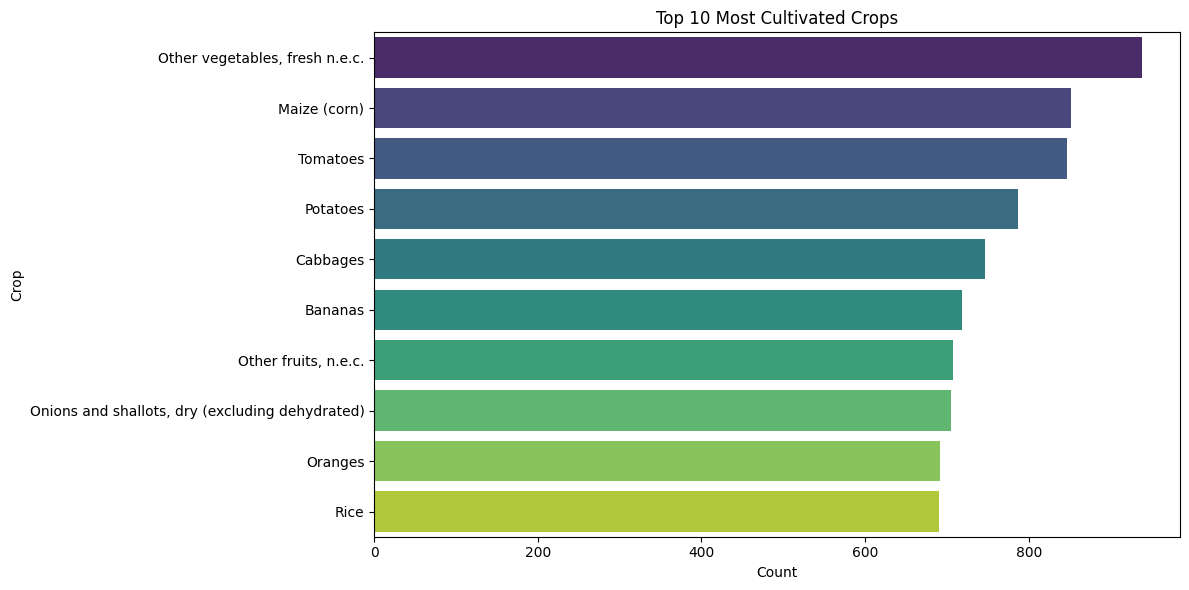

In [28]:
plt.figure(figsize=(12, 6))
sns.barplot(data=high_cult_crop, x='Cultivated_Count', y='Item', hue='Item', palette='viridis', legend=False)
plt.title('Top 10 Most Cultivated Crops')
plt.xlabel('Count')
plt.ylabel('Crop')
plt.tight_layout()
plt.show()

In [29]:
least_cult_crop=crop_counts.tail(10).sort_values(by='Cultivated_Count',ascending= True).reset_index(drop=True).rename(index=lambda x:x+1)
least_cult_crop

,Item,Cultivated_Count
1,Jojoba seeds,5
2,"Kapok fibre, raw",8
3,Kapokseed in shell,8
4,Tallowtree seeds,10
5,Kapok fruit,10
6,Other sugar crops n.e.c.,15
7,Maté leaves,15
8,"Brazil nuts, in shell",15
9,Quinoa,19
10,Cashewapple,20


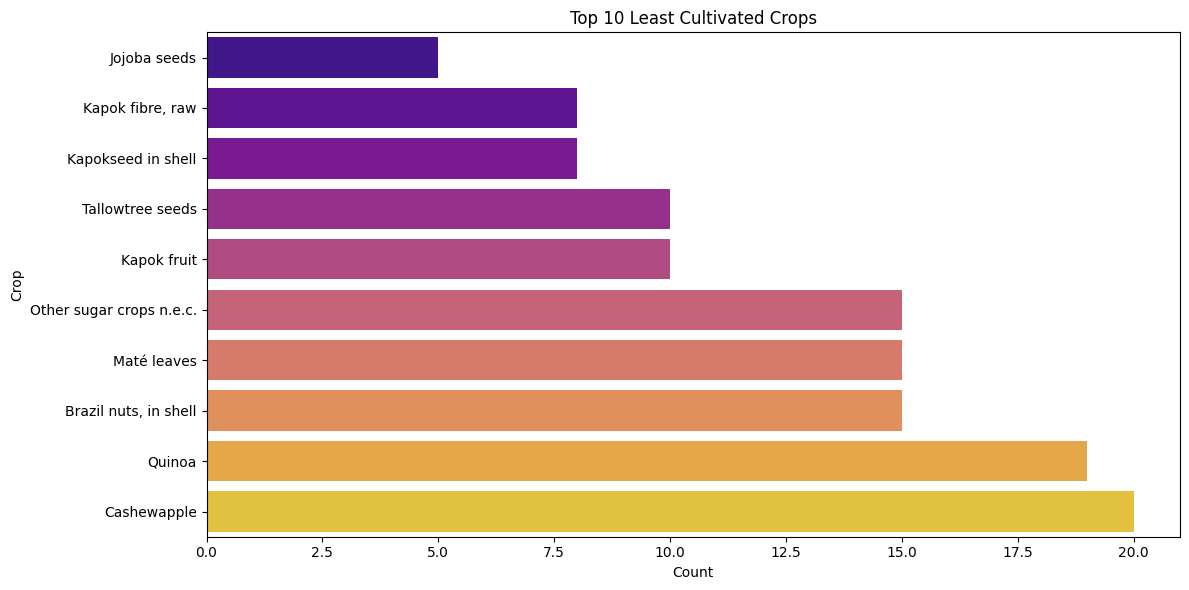

In [30]:
plt.figure(figsize=(12, 6))
sns.barplot(data=least_cult_crop, x='Cultivated_Count', y='Item', hue='Item', palette='plasma', legend=False)
plt.title('Top 10 Least Cultivated Crops')
plt.xlabel('Count')
plt.ylabel('Crop')
plt.tight_layout()
plt.show()

## ***Analyse Livestock distribution***

### **Livestock and Its Products**

In [31]:
livestock_counts= df_livestock['Item'].value_counts().reset_index(name='Product_Count').rename(index=lambda x: x + 1)
livestock_counts

,Item,Product_Count
1,"Meat of chickens, fresh or chilled",975
2,Cattle,965
3,"Hen eggs in shell, fresh",962
4,"Cattle fat, unrendered",960
5,Raw hides and skins of cattle,960
...,...,...
88,Ghee from buffalo milk,16
89,Other rodents,10
90,Other camelids,10
91,"Meat of other domestic rodents, fresh or chilled",10


In [32]:
most_prod=livestock_counts.head(10).reset_index(drop=True).rename(index=lambda x: x + 1)
most_prod

,Item,Product_Count
1,"Meat of chickens, fresh or chilled",975
2,Cattle,965
3,"Hen eggs in shell, fresh",962
4,"Cattle fat, unrendered",960
5,Raw hides and skins of cattle,960
6,"Meat of cattle with the bone, fresh or chilled",960
7,"Edible offal of cattle, fresh, chilled or frozen",960
8,Raw milk of cattle,935
9,Chickens,933
10,Goats,921


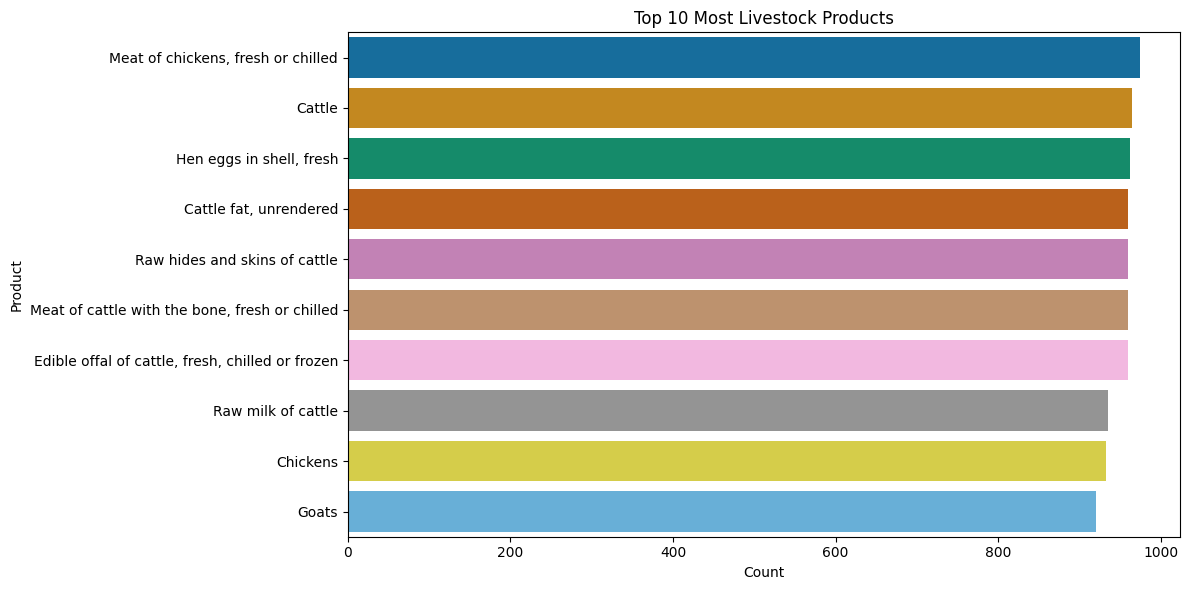

In [33]:
plt.figure(figsize=(12, 6))
sns.barplot(data= most_prod, x='Product_Count', y='Item', hue='Item', palette='colorblind', legend=False)
plt.title('Top 10 Most Livestock Products')
plt.xlabel('Count')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

In [34]:
least_prod=livestock_counts.tail(10).sort_values(by='Product_Count', ascending=True).reset_index(drop=True).rename(index=lambda x: x + 1)
least_prod

,Item,Product_Count
1,Other rodents,10
2,Other camelids,10
3,"Meat of other domestic camelids, fresh or chilled",10
4,"Meat of other domestic rodents, fresh or chilled",10
5,"Meat of mules, fresh or chilled",16
6,Ghee from buffalo milk,16
7,"Skim milk, evaporated",20
8,"Snails, fresh, chilled, frozen, dried, salted ...",20
9,Other birds,35
10,"Meat of pigeons and other birds n.e.c., fresh,...",35


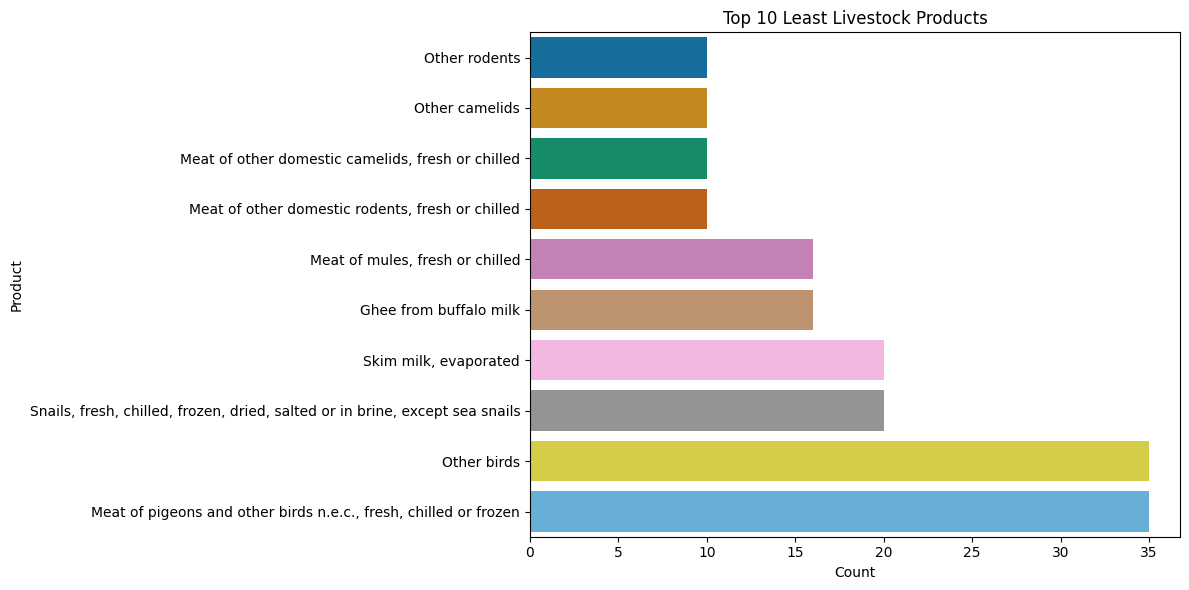

In [35]:
plt.figure(figsize=(12, 6))
sns.barplot(data= least_prod, x='Product_Count', y='Item', hue='Item', palette='colorblind', legend=False)
plt.title('Top 10 Least Livestock Products')
plt.xlabel('Count')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

## **Geographical Distribution**

### **Area Wise Crops Distribution**

In [36]:
area_crop_counts = df_crop['Area'].value_counts().reset_index(name='Crop_Count').rename(index=lambda x: x + 1)
area_crop_counts

,Area,Crop_Count
1,China,691
2,"China, mainland",667
3,Mexico,633
4,Türkiye,552
5,Peru,531
...,...,...
196,Tuvalu,29
197,Tokelau,24
198,Marshall Islands,9
199,Faroe Islands,5


In [37]:
most_cul_area =area_crop_counts.head(10)
most_cul_area

,Area,Crop_Count
1,China,691
2,"China, mainland",667
3,Mexico,633
4,Türkiye,552
5,Peru,531
6,Morocco,521
7,United States of America,515
8,Iran (Islamic Republic of),476
9,Kenya,472
10,Ukraine,465


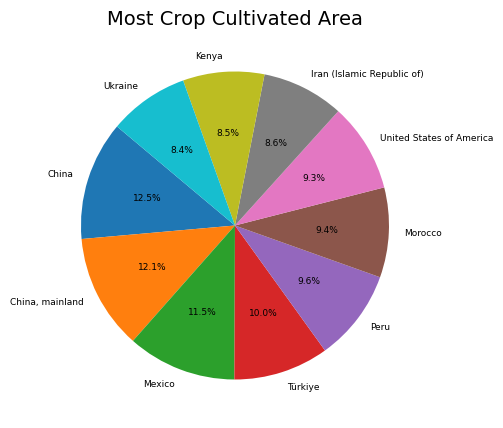

In [38]:
plt.figure(figsize=(5, 5))
plt.pie(
    most_cul_area['Crop_Count'],              
    labels=most_cul_area['Area'],             
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 6.5}
)

plt.title('Most Crop Cultivated Area', fontsize=14)
plt.show()

In [39]:
least_cul_area=area_crop_counts.tail(10).sort_values(by='Crop_Count', ascending=True).reset_index(drop=True).rename(index=lambda x: x + 1)
least_cul_area

,Area,Crop_Count
1,"China, Macao SAR",5
2,Faroe Islands,5
3,Marshall Islands,9
4,Tokelau,24
5,Tuvalu,29
6,Kiribati,38
7,Niue,50
8,Micronesia (Federated States of),59
9,Lesotho,61
10,Iceland,61


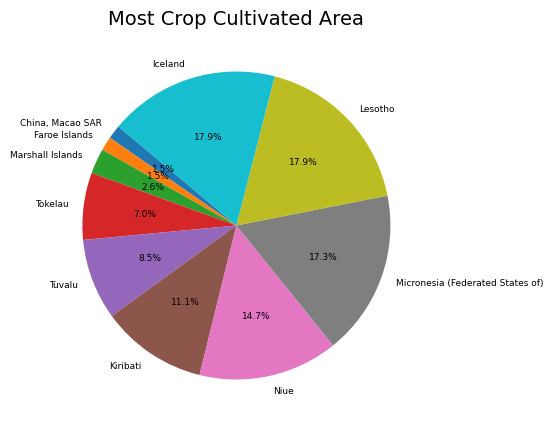

In [40]:
plt.figure(figsize=(5, 5))
plt.pie(
    least_cul_area['Crop_Count'],              
    labels=least_cul_area['Area'],             
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 6.5}
)

plt.title('Most Crop Cultivated Area', fontsize=14)
plt.show()

### ***Area wise Livestock & Products distribution***

In [41]:
livestock_products =df_livestock['Area'].value_counts().reset_index(name='Livestock_Product_Count').rename(index=lambda x: x + 1)
livestock_products

,Area,Livestock_Product_Count
1,China,359
2,"China, mainland",330
3,Egypt,309
4,Türkiye,308
5,Russian Federation,285
...,...,...
196,Kiribati,38
197,Nauru,35
198,Tokelau,35
199,Maldives,8


In [42]:
high_livestock_prod =livestock_products.head(10)
high_livestock_prod

,Area,Livestock_Product_Count
1,China,359
2,"China, mainland",330
3,Egypt,309
4,Türkiye,308
5,Russian Federation,285
6,Iran (Islamic Republic of),284
7,Kazakhstan,282
8,Syrian Arab Republic,282
9,Argentina,275
10,Ukraine,272


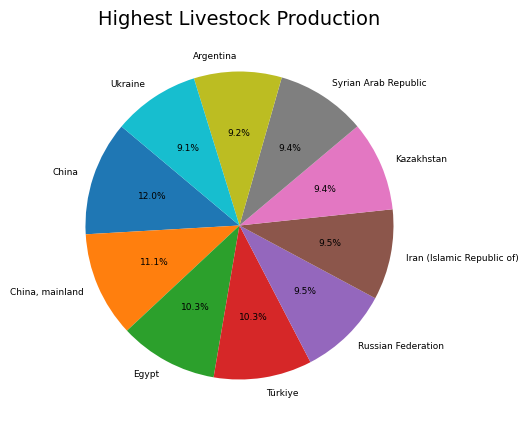

In [43]:
plt.figure(figsize=(5, 5))
plt.pie(
    high_livestock_prod['Livestock_Product_Count'],              
    labels=high_livestock_prod['Area'],             
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 6.5}
)

plt.title('Highest Livestock Production', fontsize=14)
plt.show()

In [44]:
low_livestock_prod=livestock_products.tail(10).sort_values(by='Livestock_Product_Count', ascending=True).reset_index(drop=True).rename(index=lambda x: x + 1)
low_livestock_prod

,Area,Livestock_Product_Count
1,Marshall Islands,4
2,Maldives,8
3,Nauru,35
4,Tokelau,35
5,Kiribati,38
6,Tuvalu,49
7,Faroe Islands,55
8,Solomon Islands,73
9,Niue,75
10,Samoa,89


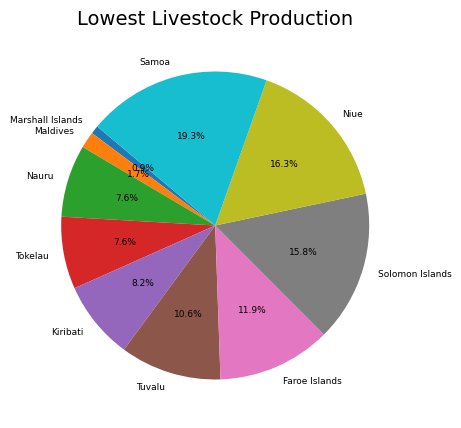

In [45]:
plt.figure(figsize=(5, 5))
plt.pie(
    low_livestock_prod['Livestock_Product_Count'],              
    labels=low_livestock_prod['Area'],             
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 6.5}
)

plt.title('Lowest Livestock Production', fontsize=14)
plt.show()

## ***Temporal Analysis***

### **Yearly Trends**

#### ***Total Output***

In [46]:
Total_output = (
    df_crop
    .groupby(['Year', 'Item'], as_index=False)
    .agg({
        'Area harvested (ha)': 'sum',
        'Yield (kg/ha)': 'mean',          
        'Production (t)': 'sum'
    })
    .sort_values(by=['Item','Year'], ascending=[True,True])
    .reset_index(drop=True)
    .rename(index=lambda x: x + 1)
)
Total_output = Total_output.rename(columns={
    'Area harvested (ha)': 'Total Area Harvested (ha)',
    'Yield (kg/ha)': 'Average Yield (kg/ha)',
    'Production (t)': 'Total Production (t)'
})
Total_output

,Year,Item,Total Area Harvested (ha),Average Yield (kg/ha),Total Production (t)
1,2019,"Abaca, manila hemp, raw",181084.0,836.633333,109506.00
2,2020,"Abaca, manila hemp, raw",179514.0,837.316667,108558.86
3,2021,"Abaca, manila hemp, raw",179107.0,836.800000,108408.99
4,2022,"Abaca, manila hemp, raw",180005.0,834.700000,108637.90
5,2023,"Abaca, manila hemp, raw",180691.0,835.950000,108434.47
...,...,...,...,...,...
889,2019,Yautia,33509.0,12890.750000,405713.85
890,2020,Yautia,32787.0,13528.485714,408255.55
891,2021,Yautia,31508.0,13220.092857,381892.97
892,2022,Yautia,31309.0,14056.671429,379779.65


In [47]:
year_input = int(input("Enter the year: "))
item_input = input("Enter the crop name: ")
data1 = Total_output[ (Total_output['Year'] == year_input) &
    (Total_output['Item'].str.lower() == item_input.lower())
]
if not data1.empty:
    data1 = data1.copy()
    display_cols = ['Year', 'Item', 'Total Area Harvested (ha)','Average Yield (kg/ha)','Total Production (t)']
    print(data1[display_cols].to_string(index=False))
else:
    print("No data found for that crop, year, and area.")

Enter the year:  2020
Enter the crop name:  Rice


 Year Item  Total Area Harvested (ha)  Average Yield (kg/ha)  Total Production (t)
 2020 Rice                195476132.0            3513.939855          988724916.44


#### ***Total Output by Area***

In [48]:
Total_output_area = (
    df_crop
    .groupby(['Year', 'Item','Area'], as_index=False)
    .agg({
        'Area harvested (ha)': 'sum',
        'Yield (kg/ha)': 'mean',          
        'Production (t)': 'sum'
    })
    .sort_values(by=['Item','Year','Area'], ascending=[True,True,True])
    .reset_index(drop=True)
    .rename(index=lambda x: x + 1)
)
Total_output_area = Total_output_area.rename(columns={
    'Area harvested (ha)': 'Total Area Harvested (ha)',
    'Yield (kg/ha)': 'Average Yield (kg/ha)',
    'Production (t)': 'Total Production (t)'
})
Total_output_area

,Year,Item,Area,Total Area Harvested (ha),Average Yield (kg/ha),Total Production (t)
1,2019,"Abaca, manila hemp, raw",Costa Rica,1080.0,1163.3,1256.36
2,2019,"Abaca, manila hemp, raw",Ecuador,29563.0,1306.5,38623.29
3,2019,"Abaca, manila hemp, raw",Equatorial Guinea,1866.0,125.4,233.99
4,2019,"Abaca, manila hemp, raw",Indonesia,688.0,815.5,560.85
5,2019,"Abaca, manila hemp, raw",Kenya,43.0,1143.9,49.19
...,...,...,...,...,...,...
55476,2023,Yautia,Peru,130.0,9092.7,1177.50
55477,2023,Yautia,Puerto Rico,190.0,5636.2,1072.70
55478,2023,Yautia,Saint Lucia,10.0,10500.0,105.00
55479,2023,Yautia,Trinidad and Tobago,186.0,9915.9,1847.75


In [49]:
year_input = int(input("Enter the year: "))
item_input = input("Enter the crop name: ")
area_input = input("Enter the country name: ")
data2 = Total_output_area[ (Total_output_area['Year'] == year_input) &
    (Total_output_area['Item'].str.lower() == item_input.lower()) &
    (Total_output_area['Area'].str.lower() == area_input.lower())
]
if not data2.empty:
    data2 = data2.copy()
    display_cols = ['Year', 'Item', 'Area','Total Area Harvested (ha)','Average Yield (kg/ha)','Total Production (t)']
    print(data2[display_cols].to_string(index=False))
else:
    print("No data found for that crop, year, and area.")

Enter the year:  2020
Enter the crop name:  Rice
Enter the country name:  India


 Year Item  Area  Total Area Harvested (ha)  Average Yield (kg/ha)  Total Production (t)
 2020 Rice India                 45769000.0                 4075.7           186543000.0


#### **Total Production**

In [50]:
Total_production = (
    df_livestock
    .groupby(['Year', 'Item'], as_index=False)
    .agg({
        'Laying (No)': 'sum',
        'Milk Animals (No)': 'sum',
        'Stocks (No)': 'sum',
        'Production (No)': 'sum',
        'Production (t)': 'sum',
        'Yield (No/An)': 'mean',  
        'Yield (mg/No)': 'mean',
        'Yield/Carcass Weight (mg/No)': 'mean'
    })
    .sort_values(by=['Item', 'Year'], ascending=[True, True])
    .reset_index(drop=True)
    .rename(index=lambda x: x + 1)
)

Total_production = Total_production.rename(columns={
    'Laying (No)': 'Total Laying (No)',
    'Milk Animals (No)': 'Total Milk Animals (No)',
    'Stocks (No)': 'Total Stocks (No)',
    'Production (No)': 'Total Production (No)',
    'Production (t)': 'Total Production (t)',
    'Yield (No/An)': 'Average Yield (No/An)',
    'Yield (mg/No)': 'Average Yield (mg/No)',
    'Yield/Carcass Weight (mg/No)': 'Average Yield/Carcass Weight (mg/No)'
})
Total_production

,Year,Item,Total Laying (No),Total Milk Animals (No),Total Stocks (No),Total Production (No),Total Production (t),Average Yield (No/An),Average Yield (mg/No),Average Yield/Carcass Weight (mg/No)
1,2019,Asses,0.0,0.0,53969658.0,0.0,0.00,0.0,0.0,0.0
2,2020,Asses,0.0,0.0,55075455.0,0.0,0.00,0.0,0.0,0.0
3,2021,Asses,0.0,0.0,54010163.0,0.0,0.00,0.0,0.0,0.0
4,2022,Asses,0.0,0.0,53198668.0,0.0,0.00,0.0,0.0,0.0
5,2023,Asses,0.0,0.0,54413589.0,0.0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
429,2022,"Whole milk, evaporated",0.0,0.0,0.0,0.0,3133754.76,0.0,0.0,0.0
430,2019,Yoghurt,0.0,0.0,0.0,0.0,4633309.94,0.0,0.0,0.0
431,2020,Yoghurt,0.0,0.0,0.0,0.0,4787498.36,0.0,0.0,0.0
432,2021,Yoghurt,0.0,0.0,0.0,0.0,4546834.66,0.0,0.0,0.0


In [51]:
year_input = int(input("Enter the year: "))
item_input = input("Enter the livestock or product name: ")
data3 = Total_production[
    (Total_production['Year'] == year_input) &
    (Total_production['Item'].str.lower() == item_input.lower())
]
if not data3.empty:
    data3 = data3.copy()
    non_zero_cols = (data3 != 0).any(axis=0)
    non_zero_data = data3.loc[:, non_zero_cols].dropna(axis=1)
    print(non_zero_data.to_string(index=False))
else:
    print("No data found.")


Enter the year:  2020
Enter the livestock or product name:  Asses


 Year  Item  Total Stocks (No)
 2020 Asses         55075455.0


#### **Total Production by Area**

In [52]:
Total_production_area = (
    df_livestock
    .groupby(['Year', 'Item','Area'], as_index=False)
    .agg({
        'Laying (No)': 'sum',
        'Milk Animals (No)': 'sum',
        'Stocks (No)': 'sum',
        'Production (No)': 'sum',
        'Production (t)': 'sum',
        'Yield (No/An)': 'mean',  
        'Yield (mg/No)': 'mean',
        'Yield/Carcass Weight (mg/No)': 'mean'
    })
    .sort_values(by=['Item', 'Year','Area'], ascending=[True, True,True])
    .reset_index(drop=True)
    .rename(index=lambda x: x + 1)
)

Total_production_area = Total_production_area.rename(columns={
    'Laying (No)': 'Total Laying (No)',
    'Milk Animals (No)': 'Total Milk Animals (No)',
    'Stocks (No)': 'Total Stocks (No)',
    'Production (No)': 'Total Production (No)',
    'Production (t)': 'Total Production (t)',
    'Yield (No/An)': 'Average Yield (No/An)',
    'Yield (mg/No)': 'Average Yield (mg/No)',
    'Yield/Carcass Weight (mg/No)': 'Average Yield/Carcass Weight (mg/No)'
})
Total_production_area

,Year,Item,Area,Total Laying (No),Total Milk Animals (No),Total Stocks (No),Total Production (No),Total Production (t),Average Yield (No/An),Average Yield (mg/No),Average Yield/Carcass Weight (mg/No)
1,2019,Asses,Afghanistan,0.0,0.0,1402909.0,0.0,0.00,0.0,0.0,0.0
2,2019,Asses,Albania,0.0,0.0,55000.0,0.0,0.00,0.0,0.0,0.0
3,2019,Asses,Algeria,0.0,0.0,86431.0,0.0,0.00,0.0,0.0,0.0
4,2019,Asses,Angola,0.0,0.0,4493.0,0.0,0.00,0.0,0.0,0.0
5,2019,Asses,Antigua and Barbuda,0.0,0.0,1723.0,0.0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
36938,2022,Yoghurt,Thailand,0.0,0.0,0.0,0.0,23277.18,0.0,0.0,0.0
36939,2022,Yoghurt,Togo,0.0,0.0,0.0,0.0,2301.09,0.0,0.0,0.0
36940,2022,Yoghurt,Türkiye,0.0,0.0,0.0,0.0,9954.22,0.0,0.0,0.0
36941,2022,Yoghurt,Uruguay,0.0,0.0,0.0,0.0,12287.98,0.0,0.0,0.0


## year_input = int(input("Enter the year: "))
item_input = input("Enter the livestock or product name: ")
area_input = input("Enter the country name: ")
data4 = Total_production_area[(Total_production_area['Year'] == year_input) &
    (Total_production_area['Item'].str.lower() == item_input.lower()) &
    (Total_production_area['Area'].str.lower() == area_input.lower())
]
if not data4.empty:
    data4 = data4.copy()
    non_zero_cols = (data4 != 0).any(axis=0)
    non_zero_data = data4.loc[:, non_zero_cols].dropna(axis=1)
    print(non_zero_data.to_string(index=False))
else:
    print("No data found.")

## **Growth Analysis**

### **Total Crop Growth Analysis**

In [54]:
growth_df = (
    Total_output.groupby(['Item', 'Year'], as_index=False)
    .agg({
        'Total Area Harvested (ha)': 'sum',
        'Average Yield (kg/ha)': 'mean',
        'Total Production (t)': 'sum'
    })
    .sort_values(by=['Item', 'Year'])
)
growth_df['Area Growth (%)'] = growth_df.groupby('Item')['Total Area Harvested (ha)'].pct_change() * 100
growth_df['Yield Growth (%)'] = growth_df.groupby('Item')['Average Yield (kg/ha)'].pct_change() * 100
growth_df['Production Growth (%)'] = growth_df.groupby('Item')['Total Production (t)'].pct_change() * 100
growth_df=growth_df.fillna(0)
growth_df.drop(['Total Area Harvested (ha)','Average Yield (kg/ha)','Total Production (t)'], axis=1, inplace=True)
growth_df=growth_df.reset_index(drop=True).rename(index=lambda x: x + 1)
growth_df.head()

,Item,Year,Area Growth (%),Yield Growth (%),Production Growth (%)
1,"Abaca, manila hemp, raw",2019,0.000000,0.000000,0.000000
2,"Abaca, manila hemp, raw",2020,-0.867001,0.081677,-0.864921
3,"Abaca, manila hemp, raw",2021,-0.226723,-0.061705,-0.138054
4,"Abaca, manila hemp, raw",2022,0.501376,-0.250956,0.211154
5,"Abaca, manila hemp, raw",2023,0.381101,0.149754,-0.187255


Enter the crop name:  Rice


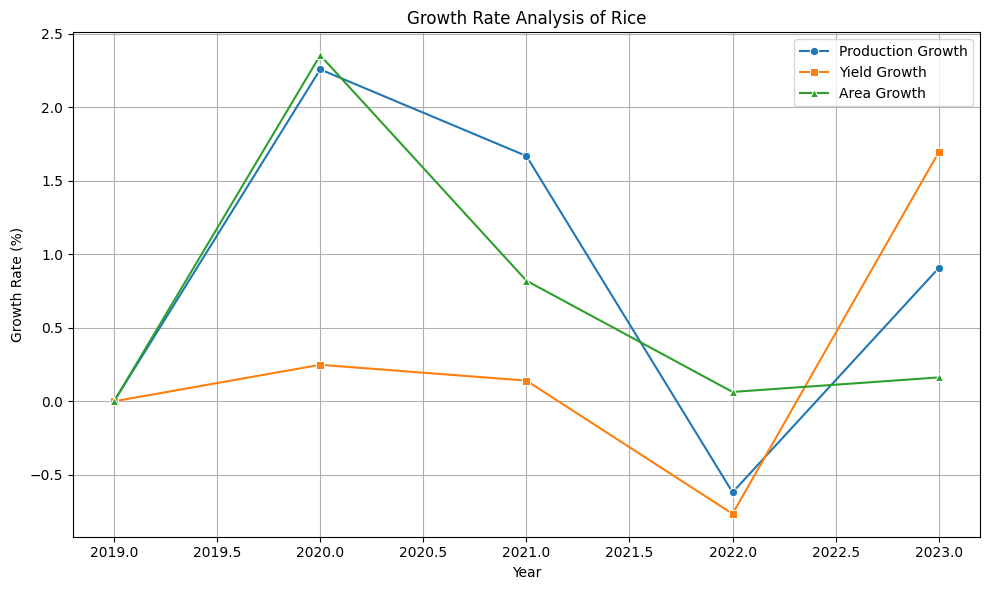

In [55]:
selected_crop = input("Enter the crop name: ").strip().title()
data5 = growth_df[growth_df['Item'].str.title() == selected_crop]

if data5.empty:
    print(f"No data found for crop: {selected_crop}")
else:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data5, x='Year', y='Production Growth (%)', marker='o', label='Production Growth')
    sns.lineplot(data=data5, x='Year', y='Yield Growth (%)', marker='s', label='Yield Growth')
    sns.lineplot(data=data5, x='Year', y='Area Growth (%)', marker='^', label='Area Growth')
    
    plt.title(f"Growth Rate Analysis of {selected_crop}")
    plt.ylabel("Growth Rate (%)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### **Crop Growth Analysis by Area**

In [56]:
grow_area = (
    Total_output_area.groupby(['Item', 'Year','Area'], as_index=False)
    .agg({
        'Total Area Harvested (ha)': 'sum',
        'Average Yield (kg/ha)': 'mean',
        'Total Production (t)': 'sum'
    })
    .sort_values(by=['Item','Area'])
)
grow_area['Area Growth (%)'] = grow_area.groupby('Item')['Total Area Harvested (ha)'].pct_change() * 100
grow_area['Yield Growth (%)'] = grow_area.groupby('Item')['Average Yield (kg/ha)'].pct_change() * 100
grow_area['Production Growth (%)'] = grow_area.groupby('Item')['Total Production (t)'].pct_change() * 100
grow_area=grow_area.fillna(0)
grow_area.drop(['Total Area Harvested (ha)','Average Yield (kg/ha)','Total Production (t)'], axis=1, inplace=True)
grow_area=grow_area.reset_index(drop=True).rename(index=lambda x: x + 1)
grow_area.head()

,Item,Year,Area,Area Growth (%),Yield Growth (%),Production Growth (%)
1,"Abaca, manila hemp, raw",2019,Costa Rica,0.000000,0.000000,0.000000
2,"Abaca, manila hemp, raw",2020,Costa Rica,-0.185185,0.240695,0.013531
3,"Abaca, manila hemp, raw",2021,Costa Rica,0.278293,-0.265843,0.093909
4,"Abaca, manila hemp, raw",2022,Costa Rica,0.000000,0.154772,0.138347
5,"Abaca, manila hemp, raw",2023,Costa Rica,0.000000,0.154533,0.138950


Enter the crop name:  Rice
Enter the region name : India


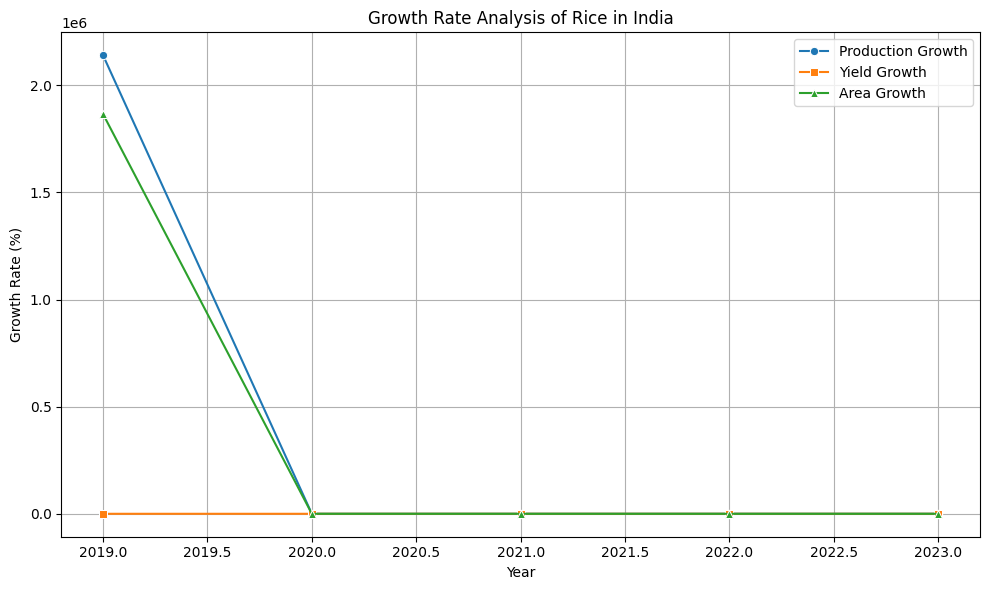

In [57]:
selected_crop = input("Enter the crop name: ").strip().title()
selected_region = input("Enter the region name :").strip().title() 
data6 = grow_area[(grow_area['Item'].str.title() == selected_crop) & (grow_area['Area'].str.title() == selected_region)]

if data6.empty:
    print(f"No data found for crop: {selected_crop} in {selected_region}")
else:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data6, x='Year', y='Production Growth (%)', marker='o', label='Production Growth')
    sns.lineplot(data=data6, x='Year', y='Yield Growth (%)', marker='s', label='Yield Growth')
    sns.lineplot(data=data6, x='Year', y='Area Growth (%)', marker='^', label='Area Growth')
    
    plt.title(f"Growth Rate Analysis of {selected_crop} in {selected_region}")
    plt.ylabel("Growth Rate (%)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### **Livestock Production Growth Analysis**

In [58]:
prod_growth = (
    Total_production.groupby(['Item', 'Year'], as_index=False)
    .agg({
        'Total Stocks (No)': 'sum',
        'Total Production (No)': 'sum',
        'Total Production (t)': 'sum',
        'Average Yield (No/An)': 'mean',  
        'Average Yield (mg/No)': 'mean',
        'Average Yield/Carcass Weight (mg/No)': 'mean'
    })
    .sort_values(by=['Item', 'Year'])
)
prod_growth['Stocks Growth (%)'] = prod_growth.groupby('Item')['Total Stocks (No)'].pct_change() * 100
prod_growth['Production1 Growth (%)'] = prod_growth.groupby('Item')['Total Production (No)'].pct_change() * 100
prod_growth['Production2 Growth (%)'] = prod_growth.groupby('Item')['Total Production (t)'].pct_change() * 100
prod_growth['Yield1 Growth (%)'] = prod_growth.groupby('Item')['Average Yield (No/An)'].pct_change() * 100
prod_growth['Yield2 Growth (%)'] = prod_growth.groupby('Item')['Average Yield (mg/No)'].pct_change() * 100
prod_growth['Yield/Carcass Weight Growth (%)'] = prod_growth.groupby('Item')['Average Yield/Carcass Weight (mg/No)'].pct_change() * 100
prod_growth=prod_growth.fillna(0)
prod_growth.drop(['Total Stocks (No)','Total Production (No)','Total Production (t)','Average Yield (No/An)','Average Yield (mg/No)','Average Yield/Carcass Weight (mg/No)'], axis=1, inplace=True)
prod_growth=prod_growth.reset_index(drop=True).rename(index=lambda x: x + 1)
prod_growth.head()

,Item,Year,Stocks Growth (%),Production1 Growth (%),Production2 Growth (%),Yield1 Growth (%),Yield2 Growth (%),Yield/Carcass Weight Growth (%)
1,Asses,2019,0.000000,0.0,0.0,0.0,0.0,0.0
2,Asses,2020,2.048923,0.0,0.0,0.0,0.0,0.0
3,Asses,2021,-1.934241,0.0,0.0,0.0,0.0,0.0
4,Asses,2022,-1.502486,0.0,0.0,0.0,0.0,0.0
5,Asses,2023,2.283743,0.0,0.0,0.0,0.0,0.0


Enter the livestock or product name:  Asses


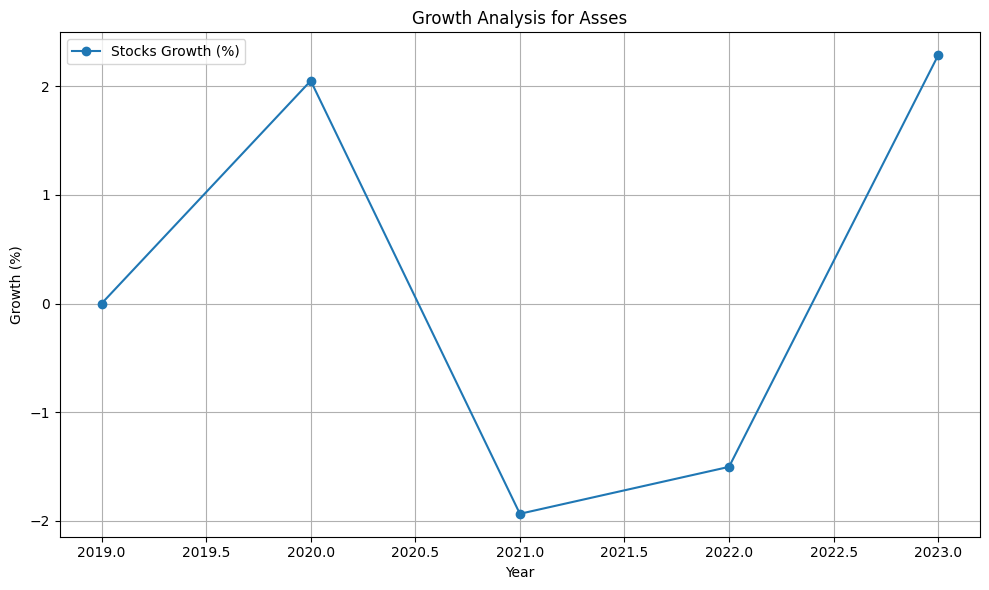

In [59]:
selected_prod = input("Enter the livestock or product name: ").strip().title()
data7 = prod_growth[prod_growth['Item'] == selected_prod].copy()

if data7.empty:
    print(f"No data found for item: {selected_prod}")
else:
    # Sort by Year (optional but recommended)
    data7 = data7.sort_values('Year')

    # Keep Year for plotting, drop only 'Item'
    plot_data = data7.drop(columns=['Item'])

    # Select columns that have at least one non-zero value
    valid_cols = plot_data.loc[:, (plot_data != 0).any(axis=0) & plot_data.notna().any(axis=0)].columns.drop('Year', errors='ignore')

    if valid_cols.empty:
        print(f"No growth data available to plot for item: {selected_prod}")
    else:
        plt.figure(figsize=(10, 6))
        for col in valid_cols:
            plt.plot(data7['Year'], data7[col], marker='o', label=col)

        plt.title(f"Growth Analysis for {selected_prod}")
        plt.xlabel("Year")
        plt.ylabel("Growth (%)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### **Livestock Production Growth Analysis by Area**

In [60]:
prod_area = (
    Total_production_area.groupby(['Item', 'Year','Area'], as_index=False)
    .agg({
        'Total Stocks (No)': 'sum',
        'Total Production (No)': 'sum',
        'Total Production (t)': 'sum',
        'Average Yield (No/An)': 'mean',  
        'Average Yield (mg/No)': 'mean',
        'Average Yield/Carcass Weight (mg/No)': 'mean'
    })
    .sort_values(by=['Item', 'Area'])
)
prod_area['Stocks Growth (%)'] = prod_area.groupby('Item')['Total Stocks (No)'].pct_change() * 100
prod_area['Production1 Growth (%)'] = prod_area.groupby('Item')['Total Production (No)'].pct_change() * 100
prod_area['Production2 Growth (%)'] = prod_area.groupby('Item')['Total Production (t)'].pct_change() * 100
prod_area['Yield1 Growth (%)'] = prod_area.groupby('Item')['Average Yield (No/An)'].pct_change() * 100
prod_area['Yield2 Growth (%)'] = prod_area.groupby('Item')['Average Yield (mg/No)'].pct_change() * 100
prod_area['Yield/Carcass Weight Growth (%)'] = prod_area.groupby('Item')['Average Yield/Carcass Weight (mg/No)'].pct_change() * 100
prod_area=prod_area.fillna(0)
prod_area.drop(['Total Stocks (No)','Total Production (No)','Total Production (t)','Average Yield (No/An)','Average Yield (mg/No)','Average Yield/Carcass Weight (mg/No)'], axis=1, inplace=True)
prod_area=prod_area.reset_index(drop=True).rename(index=lambda x: x + 1)
prod_area.head()

,Item,Year,Area,Stocks Growth (%),Production1 Growth (%),Production2 Growth (%),Yield1 Growth (%),Yield2 Growth (%),Yield/Carcass Weight Growth (%)
1,Asses,2019,Afghanistan,0.000000,0.0,0.0,0.0,0.0,0.0
2,Asses,2020,Afghanistan,8.385861,0.0,0.0,0.0,0.0,0.0
3,Asses,2021,Afghanistan,-1.793227,0.0,0.0,0.0,0.0,0.0
4,Asses,2022,Afghanistan,0.898085,0.0,0.0,0.0,0.0,0.0
5,Asses,2023,Afghanistan,0.890158,0.0,0.0,0.0,0.0,0.0


Enter the livestock or product name:  Asses
Enter the region name:  India


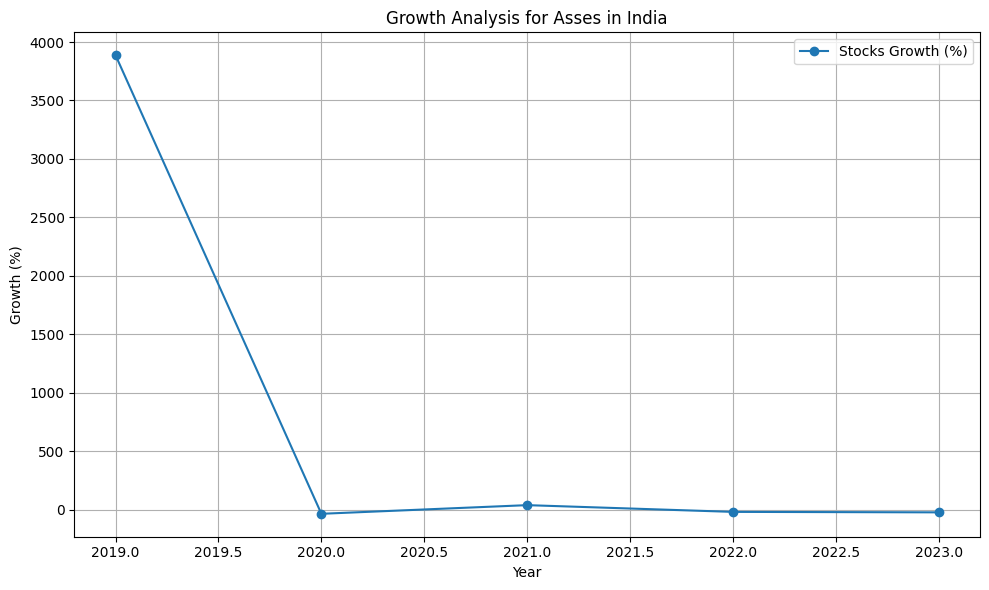

In [61]:
selected_prod = input("Enter the livestock or product name: ").strip().title()
selected_region = input("Enter the region name: ").strip().title()

data8 = prod_area[
    (prod_area['Item'].str.title() == selected_prod) & 
    (prod_area['Area'].str.title() == selected_region)
].copy()

if data8.empty:
    print(f"No data found for item: {selected_prod} in region: {selected_region}")
else:
    data8 = data8.sort_values('Year')

    plot_data1 = data8.drop(columns=['Item','Area'])

    valid_cols1 = plot_data1.loc[:, (plot_data1 != 0).any(axis=0) & plot_data1.notna().any(axis=0)].columns.drop('Year', errors='ignore')

    if valid_cols1.empty:
        print(f"No growth data available to plot for {selected_prod} in {selected_region}")
    else:
        plt.figure(figsize=(10, 6))
        for col in valid_cols1:
            plt.plot(data8['Year'], data8[col], marker='o', label=col)

        plt.title(f"Growth Analysis for {selected_prod} in {selected_region}")
        plt.xlabel("Year")
        plt.ylabel("Growth (%)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


## **Input/Output Relationship**

### **Crop Analysis**

In [62]:
from scipy.stats import pearsonr

selected_crop = input("Enter crop name: ")
selected_area = input("Enter country/region name: ")

# Filter the dataset
subset = df_crop[
    (df_crop['Item'] == selected_crop) &
    (df_crop['Area'] == selected_area) &
    (df_crop['Year'].between(2019, 2023))
]

# Proceed only if enough data is available
if len(subset) >= 2:
    # Compute correlations
    r1, _ = pearsonr(subset['Area harvested (ha)'], subset['Yield (kg/ha)'])
    r2, _ = pearsonr(subset['Area harvested (ha)'], subset['Production (t)'])
    r3, _ = pearsonr(subset['Yield (kg/ha)'], subset['Production (t)'])

    # Function to classify and interpret correlation
    def explain_relation(r, var1, var2):
        if r > 0.1:
            direction = "Positive correlation"
        elif r < -0.1:
            direction = "Negative correlation"
        else:
            direction = "No significant linear correlation"

        # Specific interpretation
        if var1 == "Area" and var2 == "Yield":
            meaning = (
                "→ More area harvested tends to increase yield per hectare." if r > 0.1 else
                "→ More area harvested tends to reduce yield per hectare." if r < -0.1 else
                "→ No clear relationship between harvested area and yield."
            )
        elif var1 == "Area" and var2 == "Production":
            meaning = (
                "→ More area harvested leads to more total production." if r > 0.1 else
                "→ More area harvested leads to lower production ." if r < -0.1 else
                "→ No clear relationship between harvested area and total production."
            )
        elif var1 == "Yield" and var2 == "Production":
            meaning = (
                "→ Higher yield per hectare results in higher total production." if r > 0.1 else
                "→ Higher yield per hectare results in lower total production." if r < -0.1 else
                "→ No clear relationship between yield and total production."
            )
        else:
            meaning = ""

        return f"{var1} vs {var2}: r = {r:.2f} ({direction})\n   {meaning}"

    # Output with interpretation
    print(subset.reset_index(drop=True).rename(index=lambda x: x + 1).drop('Area Code', axis=1))
    print(explain_relation(r1, "Area", "Yield"))
    print(explain_relation(r2, "Area", "Production"))
    print(explain_relation(r3, "Yield", "Production"))

else:
    print("Not enough data to calculate correlation.")


Enter crop name:  Apples
Enter country/region name:  India


    Area    Item  Year  Area harvested (ha)  Production (t)  Yield (kg/ha)
1  India  Apples  2019             308000.0       2316000.0         7519.5
2  India  Apples  2020             310000.0       2814000.0         9077.4
3  India  Apples  2021             313000.0       2276000.0         7271.6
4  India  Apples  2022             315000.0       2589000.0         8219.0
5  India  Apples  2023             304000.0       2876000.0         9460.5
Area vs Yield: r = -0.54 (Negative correlation)
   → More area harvested tends to reduce yield per hectare.
Area vs Production: r = -0.45 (Negative correlation)
   → More area harvested leads to lower production .
Yield vs Production: r = 0.99 (Positive correlation)
   → Higher yield per hectare results in higher total production.


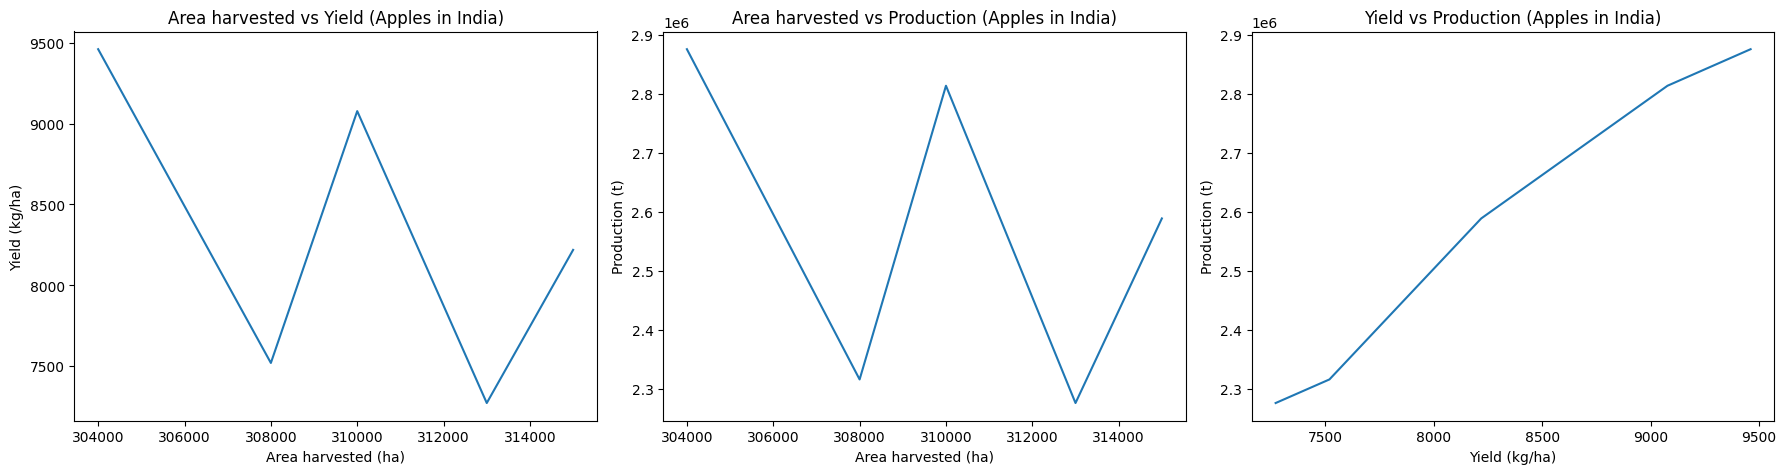

In [63]:
if len(subset) >= 2:
    plt.figure(figsize=(18, 5))

    # Area harvested vs Yield
    plt.subplot(1, 3, 1)
    sns.lineplot(x='Area harvested (ha)', y='Yield (kg/ha)', data=subset)
    plt.title(f'Area harvested vs Yield ({selected_crop} in {selected_area})')

    # Area harvested vs Production
    plt.subplot(1, 3, 2)
    sns.lineplot(x='Area harvested (ha)', y='Production (t)', data=subset)
    plt.title(f'Area harvested vs Production ({selected_crop} in {selected_area})')

    # Yield vs Production
    plt.subplot(1, 3, 3)
    sns.lineplot(x='Yield (kg/ha)', y='Production (t)', data=subset)
    plt.title(f'Yield vs Production ({selected_crop} in {selected_area})')

    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to plot.")


### **Livestock Analysis**

In [64]:
from scipy.stats import pearsonr

# User input
selected_item = input("Enter livestock item (e.g., Chickens, Camels): ")
selected_area = input("Enter country/region name: ")

# Filter data, exclude 'Stocks' entries
plot_data = df_livestock[
    (df_livestock['Item'] == selected_item) &
    (df_livestock['Area'] == selected_area) &
    (df_livestock['Year'].between(2019, 2023))
].copy()

# Identify valid (non-zero, non-null) columns
valid_cols = plot_data.loc[:, (plot_data != 0).any() & plot_data.notna().any()].columns.drop('Year', errors='ignore')

# Proceed only if enough data and relevant fields are present
if len(plot_data) >= 2 and len(valid_cols) > 0:

    # Define potential correlation pairs
    correlation_pairs = [
        ("Laying (No)", "Production (No)"),
        ("Laying (No)", "Production (t)"),
        ("Laying (No)", "Yield (No/An)"),
        ("Milk Animals (No)", "Production (t)"),
        ("Milk Animals (No)", "Yield (mg/No)"),
        ("Producing Animals/Slaughtered (No)", "Production (t)"),
        ("Producing Animals/Slaughtered (No)", "Yield/Carcass Weight (mg/No)")
    ]

    # Helper: Correlation explanation
    def explain_relation(r, var1, var2):
        if r > 0.1:
            direction = "Positive correlation"
        elif r < -0.1:
            direction = "Negative correlation"
        else:
            direction = "No significant linear correlation"
        return f"{var1} vs {var2}: r = {r:.2f} ({direction})"

    display_data = plot_data[valid_cols.union(['Year'])] if 'Year' in plot_data else plot_data[valid_cols]
    print(display_data.reset_index(drop=True).rename(index=lambda x: x + 1).drop('Area Code', axis=1))

    # Calculate correlations for only valid pairs
    valid_results = []
    for var1, var2 in correlation_pairs:
        if var1 in valid_cols and var2 in valid_cols:
            r, _ = pearsonr(plot_data[var1], plot_data[var2])
            valid_results.append(explain_relation(r, var1, var2))

    # Output results
    print("\nCorrelation Interpretations:\n")
    if valid_results:
        for result in valid_results:
            print(result)
    else:
        print(f"No correlation could be calculated for '{selected_item}' in '{selected_area}' — not enough relevant data.")

else:
    print("Not enough data or valid columns to calculate correlation.")


Enter livestock item (e.g., Chickens, Camels):  Yoghurt
Enter country/region name:  India


Not enough data or valid columns to calculate correlation.


## **Comparative Analysis**

### ***Across Crops***

In [65]:
avg_yield_by_crop = df_crop.groupby('Item')['Yield (kg/ha)'].mean().sort_values(ascending=False).reset_index(name='Average Yield').rename(index=lambda x: x + 1)
avg_yield_by_crop = avg_yield_by_crop[avg_yield_by_crop['Average Yield'] != 0]
avg_yield_by_crop

,Item,Average Yield
1,Cucumbers and gherkins,59211.723754
2,Tomatoes,58926.921133
3,Sugar cane,57573.709812
4,Sugar beet,43722.384112
5,Eggplants (aubergines),33591.774251
...,...,...
153,Cocoa beans,499.494138
154,Jojoba seeds,472.740000
155,Kola nuts,455.890000
156,"Pyrethrum, dried flowers",387.751429


In [66]:
high_yield_crop = avg_yield_by_crop.head(10)
high_yield_crop

,Item,Average Yield
1,Cucumbers and gherkins,59211.723754
2,Tomatoes,58926.921133
3,Sugar cane,57573.709812
4,Sugar beet,43722.384112
5,Eggplants (aubergines),33591.774251
6,"Chillies and peppers, green (Capsicum spp. and...",29143.127454
7,Carrots and turnips,28217.166514
8,Watermelons,27682.062388
9,Papayas,26963.379050
10,Cabbages,26346.160509


In [67]:
low_yield_crop = avg_yield_by_crop.tail(10).sort_values(by='Average Yield',ascending= True).reset_index(drop=True).rename(index=lambda x:x+1)
low_yield_crop

,Item,Average Yield
1,"Vanilla, raw",343.235065
2,"Pyrethrum, dried flowers",387.751429
3,Kola nuts,455.890000
4,Jojoba seeds,472.740000
5,Cocoa beans,499.494138
6,"Cloves (whole stems), raw",695.492000
7,"Bambara beans, dry",704.830000
8,"Agave fibres, raw, n.e.c.",741.750000
9,Hempseed,761.140000
10,Fonio,784.007273


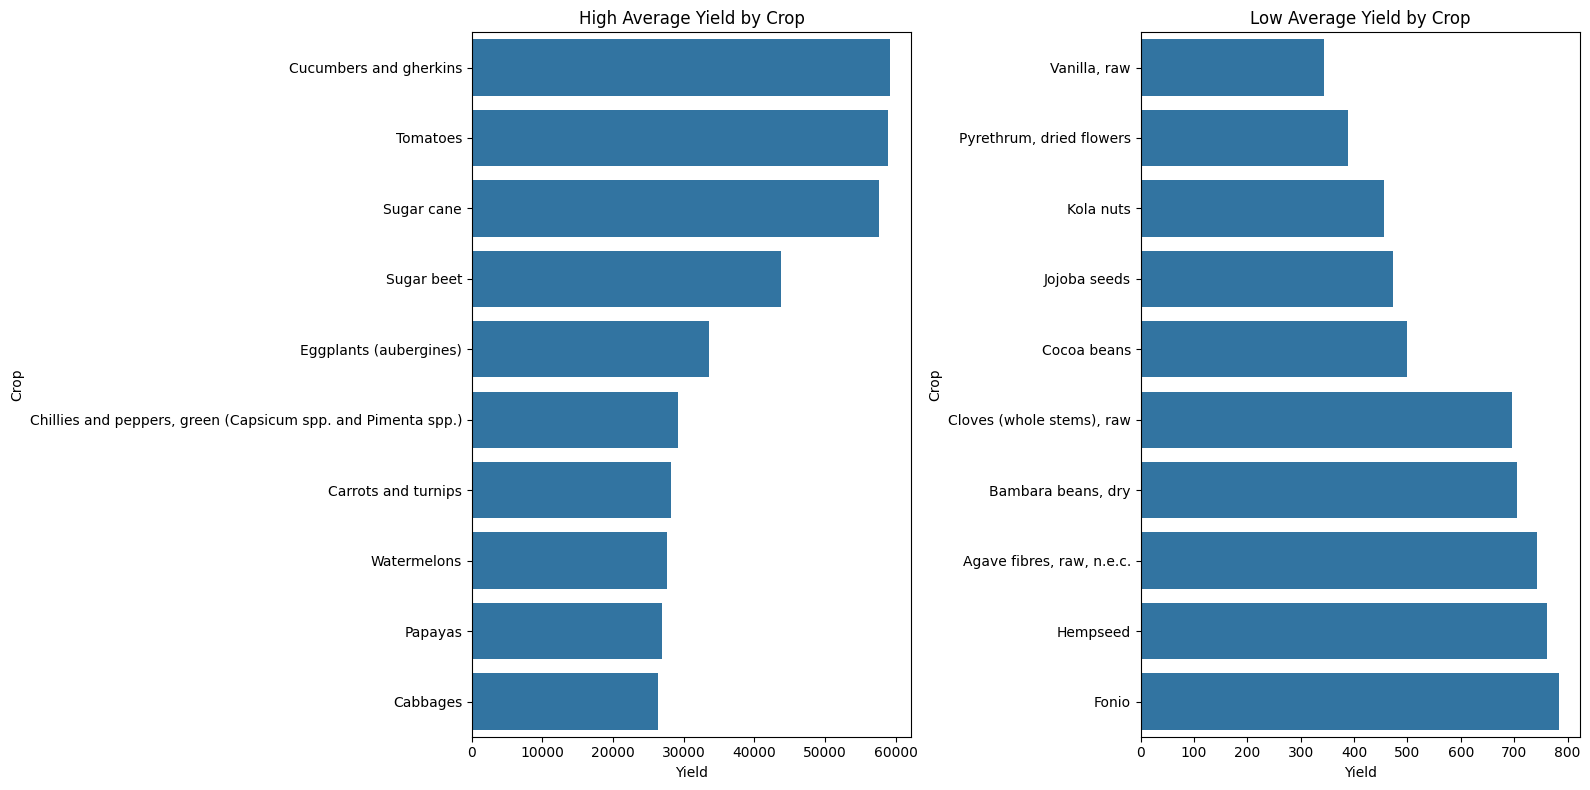

In [68]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
sns.barplot(data= high_yield_crop, x='Average Yield', y='Item')
plt.title('High Average Yield by Crop')
plt.xlabel('Yield')
plt.ylabel('Crop')

plt.subplot(1, 2, 2)
sns.barplot(data= low_yield_crop, x='Average Yield', y='Item')
plt.title('Low Average Yield by Crop')
plt.xlabel('Yield')
plt.ylabel('Crop')
plt.tight_layout()
plt.show()

In [69]:
avg_yield_by_livestock = (df_livestock.groupby('Item')[['Yield (No/An)','Yield (mg/No)','Yield/Carcass Weight (mg/No)']]
    .mean().reset_index())
avg_yield_by_livestock = avg_yield_by_livestock.dropna(how='all')
avg_yield_by_livestock = avg_yield_by_livestock[
    (avg_yield_by_livestock[['Yield (No/An)', 'Yield (mg/No)', 'Yield/Carcass Weight (mg/No)']] != 0).any(axis=1)]
avg_yield_by_livestock.index = range(1, len(avg_yield_by_livestock) + 1)
avg_yield_by_livestock

,Item,Yield (No/An),Yield (mg/No),Yield/Carcass Weight (mg/No)
1,"Eggs from other birds in shell, fresh, n.e.c.",57.920000,2.999540e+06,0.000000e+00
2,"Hen eggs in shell, fresh",167.477131,8.525822e+06,0.000000e+00
3,"Horse meat, fresh or chilled",0.000000,0.000000e+00,1.561363e+08
4,"Meat of asses, fresh or chilled",0.000000,0.000000e+00,8.166296e+07
5,"Meat of buffalo, fresh or chilled",0.000000,0.000000e+00,1.816313e+08
6,"Meat of camels, fresh or chilled",0.000000,0.000000e+00,2.065749e+08
7,"Meat of cattle with the bone, fresh or chilled",0.000000,0.000000e+00,2.022699e+08
8,"Meat of chickens, fresh or chilled",0.000000,0.000000e+00,1.356175e+06
9,"Meat of ducks, fresh or chilled",0.000000,0.000000e+00,1.574175e+06
10,"Meat of geese, fresh or chilled",0.000000,0.000000e+00,2.632357e+06


### ***Across Regions***

In [70]:
total_production_by_area = df_crop.groupby('Area')['Production (t)'].sum().sort_values(ascending=False).reset_index(name='Total Production (t)').rename(index=lambda x:x+1)
total_production_by_area

,Area,Total Production (t)
1,China,9.721251e+09
2,"China, mainland",9.677323e+09
3,India,6.267105e+09
4,Brazil,5.849517e+09
5,United States of America,3.738294e+09
...,...,...
196,Tokelau,2.550123e+04
197,Tuvalu,2.024070e+04
198,Nauru,1.464345e+04
199,Faroe Islands,7.606560e+03


In [71]:
high_prod_area=total_production_by_area.head(10)
high_prod_area

,Area,Total Production (t)
1,China,9.721251e+09
2,"China, mainland",9.677323e+09
3,India,6.267105e+09
4,Brazil,5.849517e+09
5,United States of America,3.738294e+09
6,Indonesia,2.385476e+09
7,Russian Federation,1.323460e+09
8,Nigeria,1.100229e+09
9,Thailand,1.082200e+09
10,Argentina,8.909151e+08


In [72]:
low_prod_area=total_production_by_area.tail(10).sort_values(by= 'Total Production (t)',ascending = True).reset_index(drop=True).rename(index=lambda x:x+1)
low_prod_area

,Area,Total Production (t)
1,"China, Macao SAR",1098.63
2,Faroe Islands,7606.56
3,Nauru,14643.45
4,Tuvalu,20240.70
5,Tokelau,25501.23
6,Cook Islands,26092.64
7,Niue,40116.38
8,Maldives,47691.59
9,Saint Kitts and Nevis,49114.52
10,Antigua and Barbuda,57914.18


In [73]:
prod_by_livestock = (df_livestock.groupby('Area')[['Production (No)','Production (t)']]
    .sum().reset_index().rename(index=lambda x:x+1))
prod_by_livestock 

,Area,Production (No),Production (t)
1,Afghanistan,1.928881e+09,16079082.41
2,Albania,4.311721e+09,6552163.56
3,Algeria,3.112524e+10,24440093.59
4,Angola,9.777364e+09,3823230.96
5,Antigua and Barbuda,6.921000e+07,16217.40
...,...,...,...
196,Venezuela (Bolivarian Republic of),1.611204e+10,20635679.48
197,Vietnam,4.532822e+10,37328156.19
198,Yemen,7.273333e+09,5559838.40
199,Zambia,6.361254e+09,4841381.16


In [74]:
top_prod = prod_by_livestock.sort_values(by='Production (t)', ascending=False).head(10).reset_index(drop=True).rename(index=lambda x:x+1)
top_prod = top_prod.drop('Production (No)', axis=1)
top_prod

,Area,Production (t)
1,India,1.250894e+09
2,United States of America,9.574587e+08
3,China,9.083156e+08
4,"China, mainland",8.940319e+08
5,Brazil,3.886522e+08
6,Pakistan,3.505442e+08
7,Germany,2.877880e+08
8,Russian Federation,2.780304e+08
9,France,2.129833e+08
10,Türkiye,1.653557e+08


In [75]:
top_prod1 = prod_by_livestock.sort_values(by='Production (No)', ascending=False).head(10).reset_index(drop=True).rename(index=lambda x:x+1)
top_prod1 = top_prod1.drop('Production (t)', axis=1)
top_prod1

,Area,Production (No)
1,China,3.364434e+12
2,"China, mainland",3.329828e+12
3,Indonesia,6.508706e+11
4,India,6.471796e+11
5,United States of America,5.553759e+11
6,Brazil,3.048259e+11
7,Mexico,2.884214e+11
8,Russian Federation,2.274336e+11
9,Japan,2.146895e+11
10,Pakistan,1.086428e+11


In [76]:
low_prod = prod_by_livestock.sort_values(by='Production (t)', ascending=True).head(10).reset_index(drop=True).rename(index=lambda x:x+1)
low_prod = low_prod.drop('Production (No)', axis=1)
low_prod

,Area,Production (t)
1,Marshall Islands,0.00
2,Tokelau,334.04
3,Nauru,492.25
4,Niue,922.15
5,Tuvalu,1149.13
6,Saint Kitts and Nevis,2142.29
7,Cook Islands,2893.80
8,Maldives,4351.93
9,Equatorial Guinea,5085.29
10,Micronesia (Federated States of),9479.89


In [77]:
low_prod1 = prod_by_livestock.sort_values(by='Production (No)', ascending=True).head(10).reset_index(drop=True).rename(index=lambda x:x+1)
low_prod1 = low_prod1.drop('Production (t)', axis=1)
low_prod1

,Area,Production (No)
1,Belgium,0.0
2,Faroe Islands,0.0
3,Djibouti,0.0
4,Marshall Islands,0.0
5,Netherlands (Kingdom of the),0.0
6,Maldives,0.0
7,South Sudan,0.0
8,Tokelau,680000.0
9,Nauru,902000.0
10,Niue,1856000.0


## **Productivity Analysis**

In [78]:
avg_yield_by_region = (df_crop.groupby('Area')['Yield (kg/ha)'].mean()
                       .sort_values(ascending=False).reset_index(name='Average Yield (kg/ha)').rename(index=lambda x:x+1))
avg_yield_by_region

,Area,Average Yield (kg/ha)
1,Iceland,79220.803279
2,Guyana,46153.441597
3,Oman,40713.066013
4,Netherlands (Kingdom of the),35749.404043
5,United Kingdom of Great Britain and Northern I...,32956.066122
...,...,...
196,Mauritania,2110.453535
197,Gambia,1902.566019
198,"China, Macao SAR",1703.000000
199,Eritrea,1005.111811


In [79]:
top_yield_region=avg_yield_by_region.head(10)
top_yield_region

,Area,Average Yield (kg/ha)
1,Iceland,79220.803279
2,Guyana,46153.441597
3,Oman,40713.066013
4,Netherlands (Kingdom of the),35749.404043
5,United Kingdom of Great Britain and Northern I...,32956.066122
6,Kuwait,29601.537500
7,Bahrain,29547.555714
8,United Arab Emirates,28503.253896
9,Belgium,28036.334314
10,Norway,26248.331481


In [80]:
low_yield_region=avg_yield_by_region.tail(10).sort_values(by='Average Yield (kg/ha)',ascending=True).reset_index(drop=True).rename(index=lambda x:x+1)
low_yield_region

,Area,Average Yield (kg/ha)
1,Malta,258.518653
2,Eritrea,1005.111811
3,"China, Macao SAR",1703.000000
4,Gambia,1902.566019
5,Mauritania,2110.453535
6,Central African Republic,2406.754634
7,Togo,2544.506019
8,Estonia,2797.517706
9,Equatorial Guinea,2826.286364
10,Lesotho,2910.806557


In [81]:
avg_yield_by_reg = df_livestock.groupby('Area')[
    ['Yield (No/An)', 'Yield (mg/No)', 'Yield/Carcass Weight (mg/No)']
].mean()
avg_yield_by_reg

,Yield (No/An),Yield (mg/No),Yield/Carcass Weight (mg/No)
Area,,,
Afghanistan,1.117021,2.504133e+07,9.400741e+06
Albania,3.741228,7.681650e+07,4.528704e+06
Algeria,5.885593,6.259461e+07,1.420173e+07
Angola,2.060606,1.598654e+07,8.667253e+06
Antigua and Barbuda,4.000000,3.930527e+07,9.715200e+06
...,...,...,...
Venezuela (Bolivarian Republic of),5.611111,2.162994e+07,1.254576e+07
Vietnam,2.783505,1.172370e+08,1.382868e+07
Yemen,3.855556,1.952805e+07,7.358904e+06


### **Productivity Ratio**

In [82]:
df_crop['Calculated Yield (kg/ha)'] = (df_crop['Production (t)'] * 1000) / df_crop['Area harvested (ha)']
df_crop['Yield Difference'] = df_crop['Yield (kg/ha)'] - df_crop['Calculated Yield (kg/ha)']
df_crop.reset_index(drop=True).rename(index=lambda x:x+1)

,Area Code,Area,Item,Year,Area harvested (ha),Production (t),Yield (kg/ha),Calculated Yield (kg/ha),Yield Difference
1,4,Afghanistan,"Almonds, in shell",2019,29203.0,38205.00,1308.3,1308.256001,0.043999
2,4,Afghanistan,"Almonds, in shell",2020,22134.0,39307.00,1775.9,1775.865185,0.034815
3,4,Afghanistan,"Almonds, in shell",2021,36862.0,64256.00,1743.2,1743.150128,0.049872
4,4,Afghanistan,"Almonds, in shell",2022,36462.0,63515.00,1742.0,1741.950524,0.049476
5,4,Afghanistan,"Almonds, in shell",2023,37000.0,67000.00,1810.8,1810.810811,-0.010811
...,...,...,...,...,...,...,...,...,...
55476,894,Zambia,Wheat,2019,22706.0,151850.47,6687.8,6687.680349,0.119651
55477,894,Zambia,Wheat,2020,26007.0,191619.80,7368.0,7368.008613,-0.008613
55478,894,Zambia,Wheat,2021,30319.0,205881.95,6790.5,6790.525743,-0.025743
55479,894,Zambia,Wheat,2022,33568.0,234924.63,6998.6,6998.469673,0.130327


## **Outlier Detection**

In [83]:
# List of columns to check for outliers
columns_to_check = ['Yield (kg/ha)', 'Production (t)']

# DataFrame to collect all outliers
outliers = pd.DataFrame()

# Loop through each column and find outliers using IQR
for col in columns_to_check:
    Q1 = df_crop[col].quantile(0.25)
    Q3 = df_crop[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Boolean mask for outliers
    mask = (df_crop[col] < lower_bound) | (df_crop[col] > upper_bound)
    outliers_in_col = df_crop[mask]
    
    print(f"{col} → {len(outliers_in_col)} outliers found")

    # Collect outliers
    outliers = pd.concat([outliers, outliers_in_col])

Yield (kg/ha) → 4550 outliers found
Production (t) → 8998 outliers found


In [84]:
outliers = outliers.drop_duplicates()
outliers.reset_index(drop=True).rename(index=lambda x:x+1)

,Area Code,Area,Item,Year,Area harvested (ha),Production (t),Yield (kg/ha),Calculated Yield (kg/ha),Yield Difference
1,4,Afghanistan,Sugar cane,2022,1705.0,58394.00,34248.7,3.424868e+04,0.019648
2,8,Albania,Cabbages,2019,2023.0,70411.00,34805.2,3.480524e+04,-0.039743
3,8,Albania,Cabbages,2020,1813.0,64951.00,35825.2,3.582515e+04,0.048318
4,8,Albania,Cabbages,2021,1992.0,69126.90,34700.5,3.470226e+04,-1.759036
5,8,Albania,Cabbages,2022,1970.0,66696.00,33855.8,3.385584e+04,-0.037563
...,...,...,...,...,...,...,...,...,...
11677,894,Zambia,Raw cane or beet sugar (centrifugal only),2021,0.0,397032.00,0.0,inf,-inf
11678,894,Zambia,Raw cane or beet sugar (centrifugal only),2022,0.0,430000.00,0.0,inf,-inf
11679,894,Zambia,Soya beans,2021,311254.0,411115.00,1320.8,1.320834e+03,-0.034431
11680,894,Zambia,Soya beans,2022,374713.0,475352.86,1268.6,1.268579e+03,0.021488


In [85]:
outliers['Area'].value_counts().reset_index(name='Count').rename(index=lambda x:x+1)

,Area,Count
1,China,425
2,"China, mainland",421
3,India,339
4,United States of America,279
5,Türkiye,241
...,...,...
173,Mongolia,5
174,Mauritania,3
175,Solomon Islands,3
176,Cook Islands,2


In [86]:
outliers['Item'].value_counts().reset_index(name='Count').rename(index=lambda x:x+1)

,Item,Count
1,Tomatoes,502
2,Potatoes,434
3,Maize (corn),430
4,Sugar cane,409
5,"Onions and shallots, dry (excluding dehydrated)",337
...,...,...
147,"Other fibre crops, raw, n.e.c.",2
148,Blueberries,2
149,Other berries and fruits of the genus vacciniu...,1
150,"Peppermint, spearmint",1


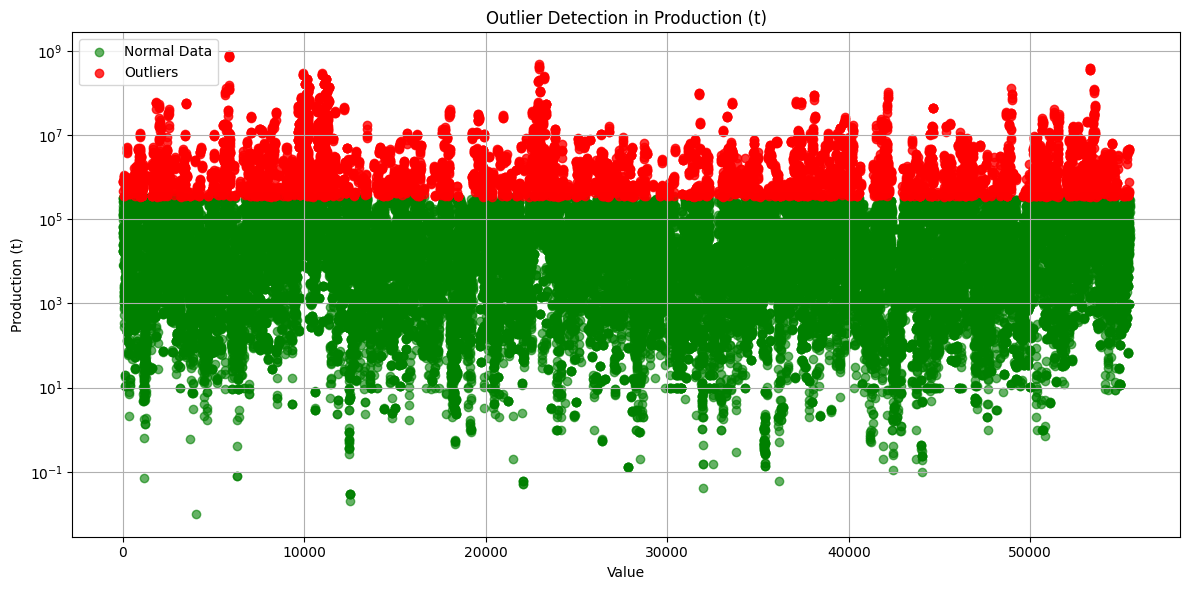

In [87]:
# IQR outlier detection for Production (t)
Q1 = df_crop['Production (t)'].quantile(0.25)
Q3 = df_crop['Production (t)'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Boolean masks
Outliers = (df_crop['Production (t)'] < lower) | (df_crop['Production (t)'] > upper)
Normal_data = ~Outliers

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(df_crop.index[Normal_data], df_crop['Production (t)'][Normal_data], color='green', label='Normal Data', alpha=0.6)
plt.scatter(df_crop.index[Outliers], df_crop['Production (t)'][Outliers], color='red', label='Outliers', alpha=0.8)
plt.yscale('log')
plt.title('Outlier Detection in Production (t)')
plt.xlabel('Value')
plt.ylabel('Production (t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [88]:
# List of columns to check for outliers
columns_to_check = ['Production (t)', 'Production (No)','Yield (No/An)','Yield (mg/No)','Yield/Carcass Weight (mg/No)']

# DataFrame to collect all outliers
outliers1 = pd.DataFrame()

# Loop through each column and find outliers using IQR
for col in columns_to_check:
    Q1 = df_livestock[col].quantile(0.25)
    Q3 = df_livestock[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Boolean mask for outliers
    mask = (df_livestock[col] < lower_bound) | (df_livestock[col] > upper_bound)
    outliers_in_col1 = df_livestock[mask]
    
    print(f"{col} → {len(outliers_in_col1)} outliers found")

    # Collect outliers
    outliers1 = pd.concat([outliers1, outliers_in_col1])

Production (t) → 6616 outliers found
Production (No) → 1124 outliers found
Yield (No/An) → 1033 outliers found
Yield (mg/No) → 5544 outliers found
Yield/Carcass Weight (mg/No) → 6307 outliers found


In [89]:
outliers1 = outliers1.drop_duplicates()
outliers1.reset_index(drop=True).rename(index=lambda x:x+1)

,Area Code,Area,Item,Year,Laying (No),Milk Animals (No),Producing Animals/Slaughtered (No),Production (No),Production (t),Stocks (No),Yield (No/An),Yield (mg/No),Yield/Carcass Weight (mg/No)
1,4,Afghanistan,Butter of cow milk,2022,0.0,0.0,0.0,0.0,38918.07,0.0,0.0,0.0,0.0
2,4,Afghanistan,"Meat of cattle with the bone, fresh or chilled",2019,0.0,0.0,625556.0,0.0,89006.91,0.0,0.0,0.0,142300000.0
3,4,Afghanistan,"Meat of cattle with the bone, fresh or chilled",2020,0.0,0.0,607512.0,0.0,88624.27,0.0,0.0,0.0,145900000.0
4,4,Afghanistan,"Meat of cattle with the bone, fresh or chilled",2021,0.0,0.0,571619.0,0.0,81784.56,0.0,0.0,0.0,143100000.0
5,4,Afghanistan,"Meat of cattle with the bone, fresh or chilled",2022,0.0,0.0,532738.0,0.0,76582.55,0.0,0.0,0.0,143800000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14479,894,Zambia,"Meat of sheep, fresh or chilled",2019,0.0,0.0,44159.0,0.0,618.26,0.0,0.0,0.0,14000000.0
14480,894,Zambia,"Meat of sheep, fresh or chilled",2020,0.0,0.0,57139.0,0.0,799.99,0.0,0.0,0.0,14000000.0
14481,894,Zambia,"Meat of sheep, fresh or chilled",2021,0.0,0.0,60877.0,0.0,852.32,0.0,0.0,0.0,14000000.0
14482,894,Zambia,"Meat of sheep, fresh or chilled",2022,0.0,0.0,69698.0,0.0,975.82,0.0,0.0,0.0,14000000.0


In [90]:
outliers1['Area'].value_counts().reset_index(name='Count').rename(index=lambda x:x+1)

,Area,Count
1,China,227
2,"China, mainland",217
3,Russian Federation,159
4,United States of America,155
5,Argentina,145
...,...,...
194,Faroe Islands,25
195,Nauru,15
196,Kiribati,15
197,Tokelau,15


In [91]:
outliers1['Item'].value_counts().reset_index(name='Count').rename(index=lambda x:x+1)

,Item,Count
1,"Meat of chickens, fresh or chilled",965
2,"Meat of cattle with the bone, fresh or chilled",960
3,"Hen eggs in shell, fresh",942
4,Raw milk of cattle,935
5,"Meat of sheep, fresh or chilled",895
...,...,...
63,Raw silk (not thrown),8
64,"Skim milk, condensed",8
65,Ghee from buffalo milk,8
66,"Skim milk, evaporated",4


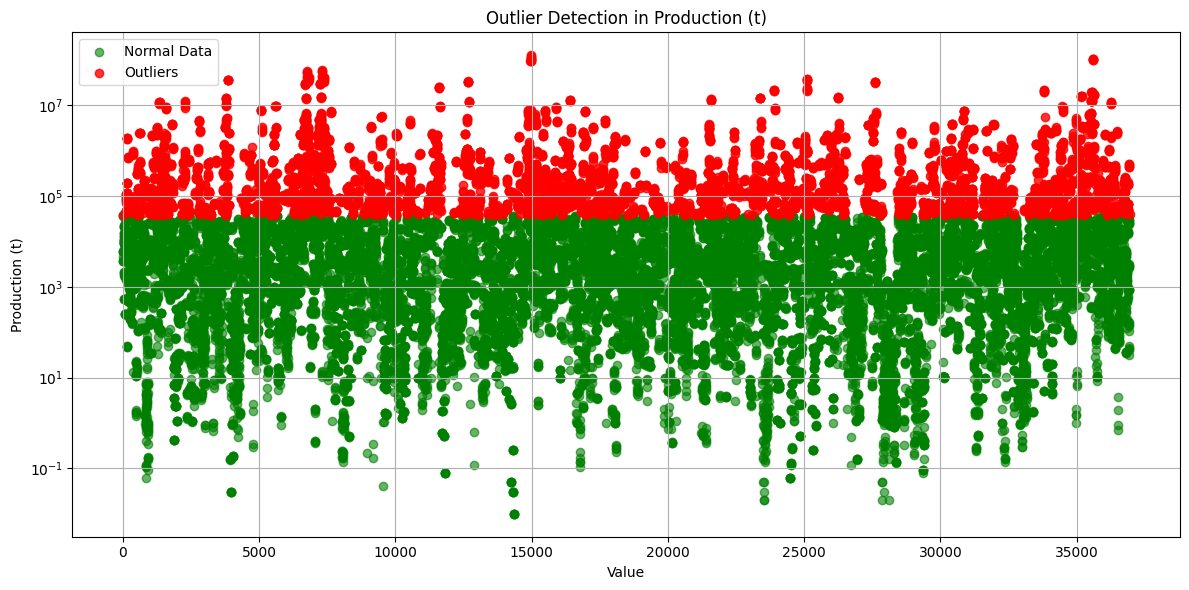

In [92]:
# IQR outlier detection for Production (t)
Q1 = df_livestock['Production (t)'].quantile(0.25)
Q3 = df_livestock['Production (t)'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Boolean masks
Outliers = (df_livestock['Production (t)'] < lower) | (df_livestock['Production (t)'] > upper)
Normal_data = ~Outliers

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(df_livestock.index[Normal_data], df_livestock['Production (t)'][Normal_data], color='green', label='Normal Data', alpha=0.6)
plt.scatter(df_livestock.index[Outliers], df_livestock['Production (t)'][Outliers], color='red', label='Outliers', alpha=0.8)
plt.yscale('log')
plt.title('Outlier Detection in Production (t)')
plt.xlabel('Value')
plt.ylabel('Production (t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Machine Learning for Predicting Production**

### **Crop Production**

In [165]:
df_crop_ml1 = df_crop_ml[
    (df_crop_ml['Area harvested (ha)'].notna()) &
    (df_crop_ml['Yield (kg/ha)'].notna()) &
    (df_crop_ml['Area harvested (ha)'] > 0) &
    (df_crop_ml['Yield (kg/ha)'] > 0)
]
df_crop_ml1

,Area Code,Area,Item,Year,Area harvested (ha),Production (t),Yield (kg/ha),Item_Encoded
0,4,Afghanistan,"Almonds, in shell",2019,29203.0,38205.00,1308.3,2
1,4,Afghanistan,"Almonds, in shell",2020,22134.0,39307.00,1775.9,2
2,4,Afghanistan,"Almonds, in shell",2021,36862.0,64256.00,1743.2,2
3,4,Afghanistan,"Almonds, in shell",2022,36462.0,63515.00,1742.0,2
4,4,Afghanistan,"Almonds, in shell",2023,37000.0,67000.00,1810.8,2
...,...,...,...,...,...,...,...,...
55475,894,Zambia,Wheat,2019,22706.0,151850.47,6687.8,179
55476,894,Zambia,Wheat,2020,26007.0,191619.80,7368.0,179
55477,894,Zambia,Wheat,2021,30319.0,205881.95,6790.5,179
55478,894,Zambia,Wheat,2022,33568.0,234924.63,6998.6,179


In [166]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [167]:
features = ['Area harvested (ha)', 'Yield (kg/ha)','Year','Item_Encoded','Area Code']
target = 'Production (t)'
X = df_crop_ml1[features]
y = df_crop_ml1[target]

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [169]:
model = RandomForestRegressor(n_estimators=300, random_state=42,criterion='squared_error')
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

In [170]:
joblib.dump(le, 'item_encoder.pkl')
joblib.dump(model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [100]:
y_pred = model.predict(X_test)

In [101]:
y_pred

array([5972335.55103333,  226202.1647    ,   14271.19743333, ...,
       1614420.89596667,  129777.7053    ,   11233.60556667],
      shape=(11207,))

In [102]:
y_test

22850    6050000.00
30095     218850.00
19026      14340.82
1384      224517.10
24977    2267750.00
            ...    
25593       8249.39
10394      74003.00
41850    1602606.00
45539     128770.00
40365      10370.00
Name: Production (t), Length: 11207, dtype: float64

In [103]:
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Now you can do:
comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_series
})

print(comparison.head())


           Actual     Predicted
22850  6050000.00  5.972336e+06
30095   218850.00  2.262022e+05
19026    14340.82  1.427120e+04
1384    224517.10  2.225911e+05
24977  2267750.00  2.191444e+06


In [105]:
from sklearn.metrics import r2_score,mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("RMSE:", rmse)
print(f"R^2 Score: {r2:.4f}")

RMSE: 5785626.751095168
R^2 Score: 0.8357


In [106]:
area = float(input("Enter Area harvested (ha): "))
yield_kg = float(input("Enter Yield (kg/ha): "))
year = int(input("Enter Year: "))
item = int(input("Enter Item Encoded value: "))
area_code = int(input("Enter Area Encoded value: "))
# Create DataFrame with same structure as training data
user_input_df = pd.DataFrame([{
    'Area harvested (ha)': area,
    'Yield (kg/ha)': yield_kg,
    'Year': year,
    'Item_Encoded': item,
    'Area Code' : area_code
}])

# Predict
prediction = model.predict(user_input_df)
# Create a mapping from area code to area name
area_code_to_name = df_crop_ml1.set_index("Area Code")["Area"].to_dict()
# Get area name from code
area_name = area_code_to_name.get(area_code, "Unknown Area")
# Create a mapping from area code to area name
item_code_to_name = df_crop_ml1.set_index("Item_Encoded")["Item"].to_dict()
# Get area name from code
item_name = item_code_to_name.get(item, "Unknown Item")
print(f"\nThe predicted production for {area_name} for {item_name} for the year {year} is {prediction[0]:2f} tonnes.")

Enter Area harvested (ha):  40404
Enter Yield (kg/ha):  330
Enter Year:  2045
Enter Item Encoded value:  04
Enter Area Encoded value:  4



The predicted production for Afghanistan for Apples for the year 2045 is 13501.322800 tonnes.


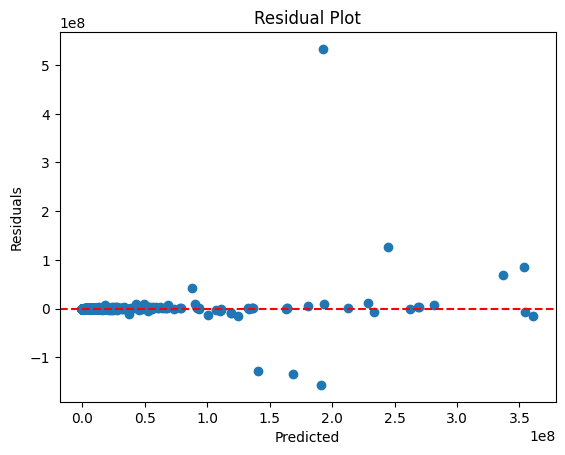

In [107]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


### **Livestock Production** 

#### **Egg Production**

In [108]:
# Filter rows where "Laying (No)" is greater than 0
filtered_df = df_livestock_ml[df_livestock_ml["Laying (No)"] > 0]

# Select only the desired columns
df_laying = filtered_df[
    ["Area Code", "Area", "Item", "Year", "Laying (No)", "Yield (mg/No)", 
     "Item_Encoded","Production (t)"]
].reset_index(drop=True)

# Convert Production (t) to kg (if needed)
df_laying["Production (t)"] = df_laying["Production (t)"] * 1000

# Drop rows where Production (t) == 0
df_laying = df_laying[df_laying["Production (t)"] != 0]

# Reset index and rename (optional, starts index from 1)
df_laying = df_laying.reset_index(drop=True).rename(index=lambda x: x + 1)

# Preview result
df_laying


,Area Code,Area,Item,Year,Laying (No),Yield (mg/No),Item_Encoded,Production (t)
1,4,Afghanistan,"Hen eggs in shell, fresh",2019,9823000.0,2116300.0,36,20787420.0
2,4,Afghanistan,"Hen eggs in shell, fresh",2021,10142000.0,2112300.0,36,21421620.0
3,4,Afghanistan,"Hen eggs in shell, fresh",2022,10148000.0,2114000.0,36,21452970.0
4,4,Afghanistan,"Hen eggs in shell, fresh",2023,10282000.0,2112700.0,36,21723600.0
5,8,Albania,"Hen eggs in shell, fresh",2019,5004000.0,10897500.0,36,54527150.0
...,...,...,...,...,...,...,...,...
999,894,Zambia,"Hen eggs in shell, fresh",2019,10873000.0,6039500.0,36,65666670.0
1000,894,Zambia,"Hen eggs in shell, fresh",2020,10996000.0,6022400.0,36,66222220.0
1001,894,Zambia,"Hen eggs in shell, fresh",2021,11121000.0,5961300.0,36,66296300.0
1002,894,Zambia,"Hen eggs in shell, fresh",2022,11248000.0,5894600.0,36,66300000.0


In [109]:
features = ['Laying (No)','Year','Item_Encoded','Yield (mg/No)','Area Code']
target = 'Production (t)'
X2 = df_laying[features]
y2 = df_laying[target]

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [111]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=42)

In [112]:
model2 = RandomForestRegressor(n_estimators=300, random_state=42,criterion='squared_error')
model2.fit(X2_train, y2_train)

RandomForestRegressor(n_estimators=300, random_state=42)

In [113]:
y2_pred = model2.predict(X2_test)

In [114]:
y2_pred

array([1.86535370e+06, 6.63589983e+07, 4.45890363e+06, 5.80772637e+06,
       4.57846487e+06, 6.19418036e+07, 7.31856219e+07, 1.51106508e+07,
       2.48450934e+07, 3.30334230e+06, 1.75438297e+06, 5.13064388e+07,
       3.14579143e+07, 7.40930583e+08, 8.03006833e+05, 1.60077226e+08,
       2.70258967e+06, 5.43756409e+07, 9.73289667e+04, 3.27309839e+09,
       1.95581233e+05, 1.12337607e+06, 1.51434453e+06, 7.50183776e+07,
       3.23370245e+07, 9.10670303e+06, 1.22038733e+05, 8.45079167e+06,
       7.23601523e+09, 7.34158877e+08, 1.34327720e+08, 1.35119340e+06,
       3.53192583e+07, 7.85424233e+05, 7.66555570e+06, 3.71209140e+06,
       1.55947167e+05, 1.12724390e+06, 6.24056707e+07, 2.65582467e+06,
       6.26740797e+06, 2.24413239e+07, 4.89064425e+07, 7.43852475e+08,
       9.23664033e+05, 9.93600333e+04, 4.17798973e+06, 8.72892011e+07,
       7.34999390e+06, 3.96556246e+08, 5.70438480e+06, 1.48645623e+08,
       1.32227670e+09, 1.12990413e+09, 3.01310049e+09, 2.51319935e+09,
      

In [115]:
y2_test

627      1880000.0
630     62756900.0
848      4584200.0
515      4800000.0
366      4601170.0
          ...     
982    452992620.0
110       583310.0
600         9120.0
78     113806850.0
85      19470000.0
Name: Production (t), Length: 251, dtype: float64

In [116]:
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Now you can do:
comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_series
})

print(comparison.head())


           Actual     Predicted
22850  6050000.00  5.972336e+06
30095   218850.00  2.262022e+05
19026    14340.82  1.427120e+04
1384    224517.10  2.225911e+05
24977  2267750.00  2.191444e+06


In [117]:
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
mae = mean_absolute_error(y2_test, y2_pred)
mse = mean_squared_error(y2_test, y2_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y2_test, y2_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print("MSE:", mse)
print("RMSE:", rmse)
print(f"R^2 Score: {r2:.4f}")

Mean Absolute Error: 24564338.66
MSE: 1.275062277394309e+16
RMSE: 112918655.56205976
R^2 Score: 0.9983


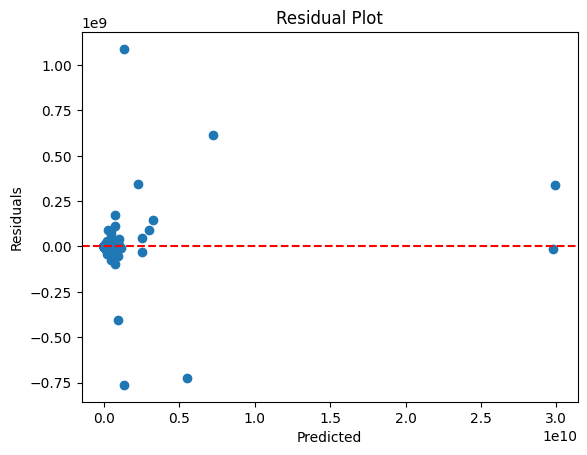

In [118]:
residuals = y2_test - y2_pred

plt.scatter(y2_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

#### **Milk Production**

In [119]:
# Filter rows where "Laying (No)" is greater than 0
filtered_df1 = df_livestock_ml[df_livestock_ml["Milk Animals (No)"] > 0]

# Select only the desired columns
df_milk = filtered_df1[
    ["Area Code", "Area", "Item", "Year", "Milk Animals (No)", "Production (t)", "Yield (mg/No)", 
     "Item_Encoded"]
].reset_index(drop=True)

# Convert Production (t) to kg (if needed)
df_milk["Production (t)"] = df_milk["Production (t)"] * 1000

# Drop rows where Production (t) == 0
df_milk = df_milk[df_milk["Production (t)"] != 0]

# Reset index and rename (optional, starts index from 1)
df_milk = df_milk.reset_index(drop=True).rename(index=lambda x: x + 1)

# Preview result
df_milk


,Area Code,Area,Item,Year,Milk Animals (No),Production (t),Yield (mg/No),Item_Encoded
1,4,Afghanistan,Raw milk of camel,2019,22096.0,6876130.0,3.112000e+08,69
2,4,Afghanistan,Raw milk of camel,2020,22031.0,6860910.0,3.114000e+08,69
3,4,Afghanistan,Raw milk of camel,2021,22017.0,6858900.0,3.115000e+08,69
4,4,Afghanistan,Raw milk of camel,2022,21953.0,6843860.0,3.118000e+08,69
5,4,Afghanistan,Raw milk of camel,2023,21888.0,6828760.0,3.120000e+08,69
...,...,...,...,...,...,...,...,...
2071,894,Zambia,Raw milk of cattle,2019,340335.0,447231770.0,1.314100e+09,70
2072,894,Zambia,Raw milk of cattle,2020,333008.0,437877050.0,1.314900e+09,70
2073,894,Zambia,Raw milk of cattle,2021,351630.0,462038090.0,1.314000e+09,70
2074,894,Zambia,Raw milk of cattle,2022,391018.0,512968340.0,1.311900e+09,70


In [120]:
features = ['Milk Animals (No)','Year','Item_Encoded','Yield (mg/No)','Area Code']
target = 'Production (t)'
X3 = df_milk[features]
y3 = df_milk[target]

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [122]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.25, random_state=42)

In [123]:
model3 = RandomForestRegressor(n_estimators=300, random_state=42,criterion='squared_error')
model3.fit(X3_train, y3_train)

RandomForestRegressor(n_estimators=300, random_state=42)

In [124]:
y3_pred = model3.predict(X3_test)

In [125]:
y3_pred

array([2.19789610e+07, 3.50070393e+10, 9.96429083e+10, 2.26397533e+06,
       2.15419783e+06, 7.86130288e+09, 1.08269590e+08, 3.96275624e+07,
       4.46161117e+07, 1.18340049e+08, 6.72233183e+08, 9.07479492e+08,
       1.34358789e+07, 1.54632088e+07, 1.32560325e+10, 1.66371020e+08,
       7.15094000e+09, 3.79794273e+06, 1.16383653e+07, 1.61900231e+08,
       2.12073944e+09, 2.45106472e+09, 1.54320648e+09, 3.36524552e+07,
       1.11511092e+07, 1.43911723e+06, 1.26664151e+09, 1.98923287e+08,
       2.22190242e+08, 1.62754604e+08, 1.96369635e+08, 4.56677957e+08,
       3.35198767e+06, 3.67810584e+07, 1.32703718e+10, 1.62784803e+08,
       7.45304951e+07, 6.38734382e+08, 1.62552352e+08, 1.07697767e+08,
       4.92176333e+05, 2.59343211e+07, 5.98604575e+07, 8.04697713e+06,
       1.06892022e+09, 7.10571700e+05, 4.54188517e+08, 1.01451354e+09,
       1.01983298e+08, 5.13210177e+08, 2.02310771e+08, 9.81678967e+05,
       2.64732642e+07, 2.08997911e+07, 4.66592633e+05, 9.61270684e+08,
      

In [126]:
y3_test

882     2.237879e+07
454     1.272088e+09
2005    1.026771e+11
1354    2.322980e+06
282     2.277920e+06
            ...     
863     3.995464e+08
926     3.466811e+07
1058    1.505649e+08
344     5.529040e+06
399     3.107608e+09
Name: Production (t), Length: 519, dtype: float64

In [127]:
y3_pred_series = pd.Series(y3_pred, index=y3_test.index)

# Now you can do:
comparison = pd.DataFrame({
    'Actual': y3_test,
    'Predicted': y3_pred_series
})

print(comparison.head())

            Actual     Predicted
882   2.237879e+07  2.197896e+07
454   1.272088e+09  3.500704e+10
2005  1.026771e+11  9.964291e+10
1354  2.322980e+06  2.263975e+06
282   2.277920e+06  2.154198e+06


In [128]:
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
mae = mean_absolute_error(y3_test, y3_pred)
mse = mean_squared_error(y3_test, y3_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y3_test, y3_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print("MSE:", mse)
print("RMSE:", rmse)
print(f"R^2 Score: {r2:.4f}")

Mean Absolute Error: 206361048.43
MSE: 3.168431599869105e+18
RMSE: 1780008876.3455942
R^2 Score: 0.9703


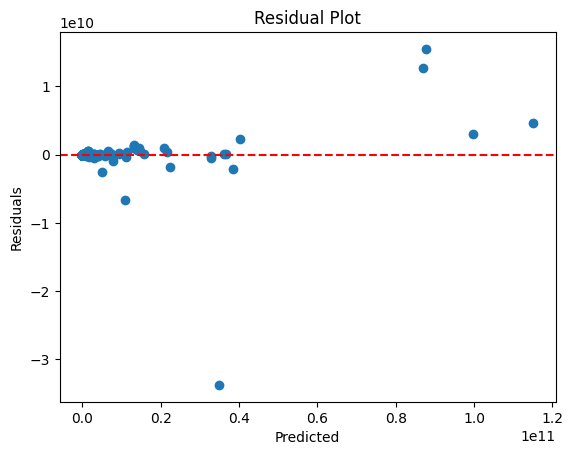

In [129]:
residuals = y3_test - y3_pred
plt.scatter(y3_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

#### **Meat Production**

In [130]:
# 1. Filter rows where Producing Animals/Slaughtered > 0
filtered_df1 = df_livestock_ml[df_livestock_ml["Producing Animals/Slaughtered (No)"] > 0]

# 2. Select relevant columns
df_slaught = filtered_df1[
    ["Area Code", "Area", "Item", "Year", "Producing Animals/Slaughtered (No)", 
     "Production (t)", "Yield/Carcass Weight (mg/No)", "Item_Encoded"]
].copy().reset_index(drop=True)

# 3. Convert Production (t) from tons to kg (if needed)
df_slaught["Production (t)"] = df_slaught["Production (t)"] * 1000

# 4. Recalculate yield where it's 0
mask = (df_slaught["Yield/Carcass Weight (mg/No)"] == 0) & \
       (df_slaught["Producing Animals/Slaughtered (No)"] > 0)

df_slaught.loc[mask, "Yield/Carcass Weight (mg/No)"] = (
    df_slaught.loc[mask, "Production (t)"] * 1_000_000_000
    / df_slaught.loc[mask, "Producing Animals/Slaughtered (No)"]
)

# 5. Drop rows with zero Production or recalculated yield still zero
df_slaught = df_slaught[
    (df_slaught["Production (t)"] != 0) & 
    (df_slaught["Yield/Carcass Weight (mg/No)"] != 0)
].reset_index(drop=True).rename(index=lambda x: x + 1)

# 6. Preview
df_slaught

,Area Code,Area,Item,Year,Producing Animals/Slaughtered (No),Production (t),Yield/Carcass Weight (mg/No),Item_Encoded
1,4,Afghanistan,"Cattle fat, unrendered",2019,625556.0,2183190.0,3.489999e+09,11
2,4,Afghanistan,"Cattle fat, unrendered",2020,607512.0,2173800.0,3.578201e+09,11
3,4,Afghanistan,"Cattle fat, unrendered",2021,571619.0,2006040.0,3.509400e+09,11
4,4,Afghanistan,"Cattle fat, unrendered",2022,532738.0,1878440.0,3.526011e+09,11
5,4,Afghanistan,"Cattle fat, unrendered",2023,492797.0,1749610.0,3.550367e+09,11
...,...,...,...,...,...,...,...,...
15811,894,Zambia,"Sheep fat, unrendered",2019,44159.0,30910.0,6.999706e+08,76
15812,894,Zambia,"Sheep fat, unrendered",2020,57139.0,40000.0,7.000473e+08,76
15813,894,Zambia,"Sheep fat, unrendered",2021,60877.0,42620.0,7.001002e+08,76
15814,894,Zambia,"Sheep fat, unrendered",2022,69698.0,48790.0,7.000201e+08,76


In [131]:
features = ['Producing Animals/Slaughtered (No)','Year','Item_Encoded','Yield/Carcass Weight (mg/No)','Area Code']
target = 'Production (t)'
X4 = df_slaught[features]
y4 = df_slaught[target]

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [133]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.25, random_state=42)

In [134]:
model4 = RandomForestRegressor(n_estimators=300, random_state=42,criterion='squared_error')
model4.fit(X4_train, y4_train)

RandomForestRegressor(n_estimators=300, random_state=42)

In [135]:
y4_pred = model4.predict(X4_test)

In [136]:
y4_pred

array([71842320.3       ,  2709386.1       ,  1112070.9       , ...,
          94406.43333333,  2261621.3       ,  2172783.83333333],
      shape=(3954,))

In [137]:
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
mae = mean_absolute_error(y4_test, y4_pred)
mse = mean_squared_error(y4_test, y4_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y4_test, y4_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print("MSE:", mse)
print("RMSE:", rmse)
print(f"R^2 Score: {r2:.4f}")

Mean Absolute Error: 15384752.18
MSE: 2.7659413166660458e+17
RMSE: 525922172.6326097
R^2 Score: 0.8598


In [138]:
y4_pred_series = pd.Series(y4_pred, index=y4_test.index)

# Now you can do:
comparison = pd.DataFrame({
    'Actual': y4_test,
    'Predicted': y4_pred_series
})

print(comparison.head())

          Actual     Predicted
9057  72442730.0  7.184232e+07
170    2653850.0  2.709386e+06
2088   1089470.0  1.112071e+06
4792     36240.0  3.320993e+04
6557   6150420.0  6.197707e+06


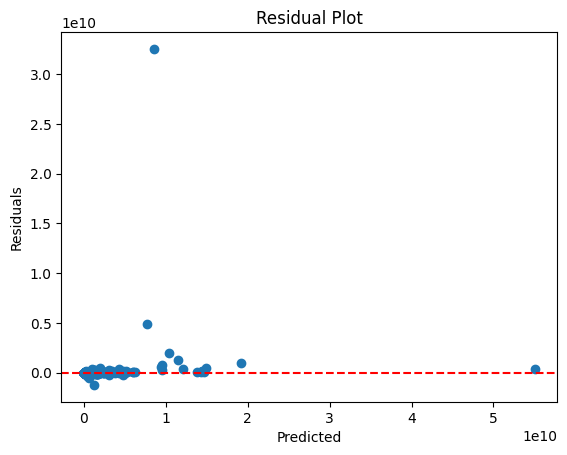

In [139]:
residuals = y4_test - y4_pred
plt.scatter(y4_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

## 